### Imports

In [32]:
import pickle
import re
import shelve
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy.stats as stats
from sklearn.metrics import pairwise_distances, silhouette_score, davies_bouldin_score

# 1. Prepare Time Series Dataset

In [3]:
dataset = pd.read_csv("data/final_dataset.csv")
print("Shape of dataset:", dataset.shape)
dataset.head()

Shape of dataset: (239381, 76)


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y
0,851.0,2015.0,Indianapolis,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,False,5.000000e-01,-0.866025
1,1553.0,2017.0,Kane,41.6645,-78.7856,62.0,62.0,62.0,0.0,1.0,...,False,False,False,False,False,False,False,False,8.660254e-01,-0.500000
2,1404.0,2016.0,Detroit,42.4190,-83.0393,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-5.000000e-01,0.866025
3,1383.0,2016.0,Washington,38.9030,-76.9820,18.0,28.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,False,-8.660254e-01,0.500000
4,894.0,2015.0,Pittsburgh,40.4621,-80.0308,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,False,1.224647e-16,-1.000000


## 1.1 Select cities

In [4]:
dataset['year'].value_counts()

year
2017.0    61389
2016.0    58724
2015.0    53335
2014.0    51684
2018.0    13801
2013.0      448
Name: count, dtype: int64

Keep only incidents regarding [2014, 2015, 2016, 2017], as by project assignment instructions.

In [5]:
dataset = dataset[(dataset['year'] > 2013) & (dataset['year'] < 2018)]

Analysis of cities reveals that many cities are present with different names, resulting in incorrect city value counts.

In [6]:
with open('debugging/cities.txt', 'w') as f:
    for item in dataset['city_or_county'].unique():
        f.write("%s\n" % item)
        
# Write city and value counts of each city to a file
with open('debugging/city_counts.txt', 'w') as f:
    f.write(dataset['city_or_county'].value_counts().to_string())

print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))
        

There are 12596 unique cities in the dataset


Eliminate parenthesis with county or extra information.

In [7]:
# Eliminate all data between parenthesis in the city column using re module
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: re.sub(r"\(.*\)", "", x))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 11762 unique cities in the dataset


Sort cities alphabetically to see if there are still duplicates and how relevant they are.

In [8]:
# Get all cities and sort them alphabetically and write them in a file
cities = dataset['city_or_county'].unique()
cities.sort()
with open('debugging/cities2.txt', 'w') as f:
    for item in cities:
        f.write("%s\n" % item)

We can see that there are many cities which differ in having a space in the end, let's remove all spaces to avoid problems.

In [9]:
# Remove all spaces from city names
dataset['city_or_county'] = dataset['city_or_county'].apply(lambda x: x.replace(" ", ""))
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10416 unique cities in the dataset


In [10]:
dataset['city_or_county'] = dataset['city_or_county'].str.upper()
print('There are {} unique cities in the dataset'.format(len(dataset['city_or_county'].unique())))

There are 10331 unique cities in the dataset


Introducing a week parameter and filtering only cities with a number of weeks with incidents greater than 15% of the total number of the weeks of the 4 years.

In [11]:
dataset['week'] = " "

# Date attribute is a progressive integer number, starting from 0
# Assign a week number to each date
dataset['date'] = dataset['date'] - dataset['date'].min()
dataset['week'] = dataset['date'].apply(lambda x: int(x / 7))

n_weeks = dataset['week'].max()
n_weeks

208

In [12]:
cities = dataset['city_or_county'].unique()
dropping_threshold = 0.15

for city in cities:
    city_data = dataset[dataset['city_or_county'] == city]
    city_weeks_with_incidents = city_data['week'].nunique()

    # Drop the city if it has less than 15% of the weeks with incidents
    if city_weeks_with_incidents < n_weeks * dropping_threshold:
        dataset = dataset[dataset['city_or_county'] != city]

print('Number of cities for which time series will be generated:', dataset['city_or_county'].nunique())
dataset.head()

Number of cities for which time series will be generated: 713


,date,year,city_or_county,latitude,longitude,min_age_participants,avg_age_participants,max_age_participants,teen_ratio,adults_ratio,...,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,month_x,month_y,week
0,486.0,2015.0,INDIANAPOLIS,39.8322,-86.2492,19.0,19.0,19.0,0.0,1.0,...,False,False,False,False,False,False,False,5.000000e-01,-8.660254e-01,69
2,1039.0,2016.0,DETROIT,42.4190,-83.0393,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,-5.000000e-01,8.660254e-01,148
3,1018.0,2016.0,WASHINGTON,38.9030,-76.9820,18.0,28.0,37.0,0.0,1.0,...,False,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,145
4,529.0,2015.0,PITTSBURGH,40.4621,-80.0308,28.0,28.0,28.0,0.0,1.0,...,False,False,False,False,False,False,False,1.224647e-16,-1.000000e+00,75
7,805.0,2016.0,NEWHAVEN,41.2945,-72.9457,24.0,24.0,24.0,1.0,0.0,...,False,False,False,False,False,False,False,1.000000e+00,6.123234e-17,115


In [13]:
# Save dataset in csv
dataset.to_csv('debugging/ts.csv', index=False)

## 1.3 Generation with different score functions for each subtask

Define the functions to compute the score for each of the two subtasks. The score used is the <b><u> perceived risk </b></u> computed in an "eligibility trace fashion", borrowing this concept from reinforcement learning rewards. We add to the score the number of incidents in the current week, and we sum the score of previous weeks, decaying it by multiplying it by a factor alpha.

In [15]:
# Define the threshold for the number of killed people in a city 
# to be considered as a label 1 class
ISKILLED_THRESHOLD = 25

def compute_week_score(week_data, task, prev_score, alpha = 0.5):
    """Compute the score for a given week, to be used in the time seriesw

    Args:
        week_data (pandas.DataFrame): Data for a given week
        task (str): Task to be performed, used for deciding score function.
        prev_score (float): Score of the previous week
        alpha (float, optional): Weight for the previous score. Defaults to 0.5.

    Returns:
        float: Score for the given week
    """
    if task == 'clustering' or task == 'shapelet_learning' or task == None:
        score = prev_score * alpha + week_data.shape[0]
    return score


def generate_time_series_with_label(city_data, n_weeks, task):
    """Generate the time series for a given city.
    Label is referred to the whole time series.

    Args:
        city_data (pandas.DataFrame): Data for a given city
        n_weeks (int): Number of weeks in the dataset
        task (str): Task to be performed, used for deciding score function.

    Returns:
        numpy.ndarray: Time series for the given city
            Shape (n_weeks, )
        int: Label for the time series
    """
    # Generate the time series for a given city
    time_series = np.zeros(n_weeks)
    for week in range(n_weeks):
        week_data = city_data[city_data['week'] == week]
        if week_data.shape[0] > 0:
            time_series[week] = compute_week_score(week_data, task, time_series[week - 1])
    
    if (city_data['killed_ratio'] * city_data['n_participants']).sum() > ISKILLED_THRESHOLD:
        label = 1
    else:
        label = 0

    return time_series, label

def generate_time_series_dataset(dataset, task = None):
    """Generate the time series dataset

    Args:
        dataset (pandas.DataFrame): Dataset
        task (str, optional): Task to be performed, used for deciding score function. Defaults to None.

    Returns:    
        list: [Time series dataset, labels]
        numpy.ndarray: Cities of the time series dataset
    """
    # Generate the time series for all cities
    n_weeks = dataset['week'].max()
    cities = dataset['city_or_county'].unique()
    time_series = []
    labels = []
    for city in cities:
        city_data = dataset[dataset['city_or_county'] == city]
        ts, label = generate_time_series_with_label(city_data, n_weeks, task)
        time_series.append(ts)
        labels.append(label)
        
    time_series = np.array(time_series)
    labels = np.array(labels)
    
    time_series = [time_series, labels]

    return time_series, cities

In [575]:
class TSScaler:
    """Base class to scale time series data
    """
    def __init__(self, verbose = True):
        self.verbose = verbose

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    
    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        return NotImplementedError
    

class FixedMinMaxScaler(TSScaler):
    """Class to scale time series data using minmax scaling.
    Scaling is performed using a fixed min and max value.
    """
    def __init__(self, verbose = True):
        super().__init__(verbose)
        self.min = None
        self.max = None

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        self.min = time_series.min(axis = 1).min(axis = 0)
        self.max = time_series.max(axis = 1).max(axis = 0)
        return self.transform(time_series)

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Scaling time series with MinMaxScaler')
        return (time_series - self.min) / (self.max - self.min)

    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.min is None or self.max is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Inverse scaling time series with MinMaxScaler')
        return time_series * (self.max - self.min) + self.min
    
class IndependentMinMaxScaler(TSScaler):
    """Class to scale time series data using minmax scaling.
    Scaling is performed independentely for each time series.
    """
    def __init__(self, verbose = True):
        super().__init__(verbose)
        self.mins = None
        self.maxs = None

    def fit_transform(self, time_series):
        """Fit and transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        self.mins = time_series.min(axis = 1)
        self.maxs = time_series.max(axis = 1)
        return self.transform(time_series)

    def transform(self, time_series):
        """Transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.mins is None or self.maxs is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Scaling time series with MinMaxScaler')
        for i in range(time_series.shape[0]):
            time_series[i] = (time_series[i] - self.mins[i]) / (self.maxs[i] - self.mins[i])
        return time_series

    def inverse_transform(self, time_series):
        """Inverse transform the time series

        Args:
            time_series (numpy.ndarray): Time series to be scaled
                Shape (n_samples, n_timesteps, n_features)

        Returns:
            numpy.ndarray: Scaled time series
                Shape (n_samples, n_timesteps, n_features)
        """
        if self.mins is None or self.maxs is None:
            raise ValueError('MinMaxScaler is not fitted')

        if self.verbose:
            print('Inverse scaling time series with MinMaxScaler')
        for i in range(time_series.shape[0]):
            time_series[i] = time_series[i] * (self.maxs[i] - self.mins[i]) + self.mins[i]
        return time_series

In our case, no resampling is necessary as all sequences are of same length, as we define them over 208 weeks. Furthermore, no approximation is needed as the resulting dataset of time series is small.

<b>Important!!!</b> Keep in mind that minmax scaler in tslearn scales each time series independently, so the two following time series of killed people in our dataset will look identical:

1. 0 - 0 - 100 - 0 - ... - 0
2. 0 - 0 -  1  - 0 - ... - 0

This is because usually one would like to do amplitude scaling on the dataset (e.g. if the signal is electrical tension, and the important thing is the shape of the signal and not the amplitude itself). However, in our case it is important to consider this loss in information. For this reason, we implement our own minmax scaler.

## 1.4 Generate time series dataset

In [17]:
ts_dataset, cities = generate_time_series_dataset(dataset)
X = ts_dataset[0]
y = ts_dataset[1]
print('Shape of X:', X.shape)   
print('Shape of y:', y.shape)

Shape of X: (713, 208)
Shape of y: (713,)


In [576]:
scaler_minmax_fixed = FixedMinMaxScaler()
scaler_minmax_independent = IndependentMinMaxScaler()

X_minmax_fixed = scaler_minmax_fixed.fit_transform(X)
X_minmax_independent = scaler_minmax_independent.fit_transform(X)

print('Shape of X_minmax_fixed:', X_minmax_fixed.shape)
print('Shape of X_minmax_independent:', X_minmax_independent.shape)

Scaling time series with MinMaxScaler
Scaling time series with MinMaxScaler
Shape of X_minmax_fixed: (713, 208, 1)
Shape of X_minmax_independent: (713, 208, 1)


We'll use the minmax scaled dataset as we defined it with our class.

In [577]:
scaler = scaler_minmax_fixed
X = X_minmax_fixed

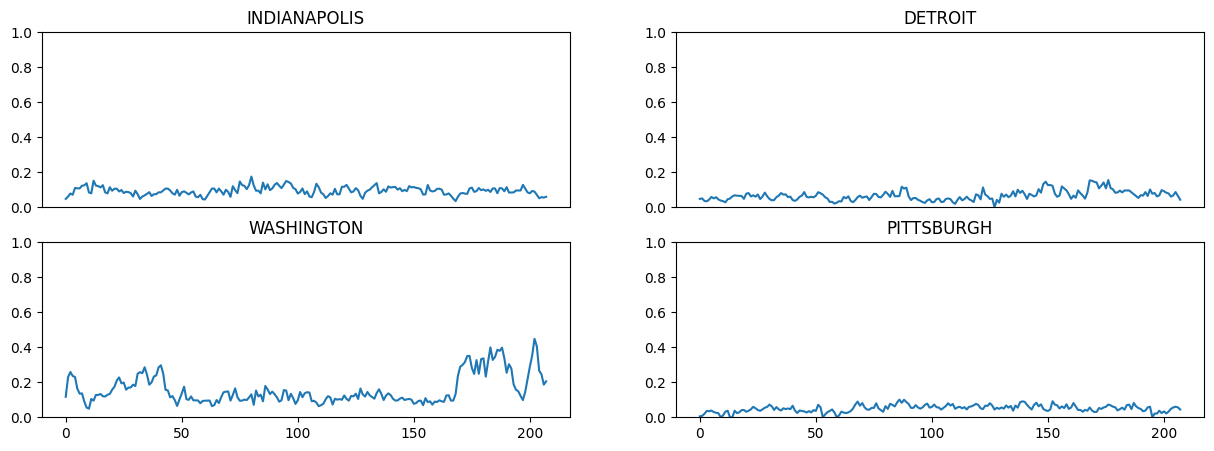

In [20]:
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(X[i])
    plt.ylim(0, 1)
    if i < 2:
        plt.xticks([])
    plt.title(cities[i])
plt.show()

Save the dataset.

In [34]:
# Dump with pickle the dataset, the cities and the labels
with open('data/ts_dataset.pkl', 'wb') as f:
    pickle.dump(X, f)
    pickle.dump(y, f)
    pickle.dump(cities, f)
    pickle.dump(scaler, f)

# 2. Clustering

## 2.1 Shape-based Clustering 

In [21]:
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.clustering import silhouette_score as ts_silhouette_score

### 2.1.1 KMeans with Euclidean Distance

In [22]:
max_k = 20

sse_list_km = []
silhouette_list_km = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100, random_state=0, n_init=10)
    km.fit(X)

    if km._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km.append(km.inertia_)
    silhouette_list_km.append(ts_silhouette_score(X, km.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 5.611 s
Finished clustering for k = 3; time elapsed: 7.501 s
Finished clustering for k = 4; time elapsed: 8.736 s
Finished clustering for k = 5; time elapsed: 8.970 s
Finished clustering for k = 6; time elapsed: 8.043 s
Finished clustering for k = 7; time elapsed: 8.493 s
Finished clustering for k = 8; time elapsed: 9.957 s
Finished clustering for k = 9; time elapsed: 7.747 s
Finished clustering for k = 10; time elapsed: 7.975 s
Finished clustering for k = 11; time elapsed: 7.272 s
Finished clustering for k = 12; time elapsed: 8.684 s
Finished clustering for k = 13; time elapsed: 8.813 s
Finished clustering for k = 14; time elapsed: 8.533 s
Finished clustering for k = 15; time elapsed: 8.584 s
Finished clustering for k = 16; time elapsed: 11.027 s
Finished clustering for k = 17; time elapsed: 11.520 s
Finished clustering for k = 18; time elapsed: 9.303 s
Finished clustering for k = 19; time elapsed: 9.376 s
Finished clustering for k = 20; ti

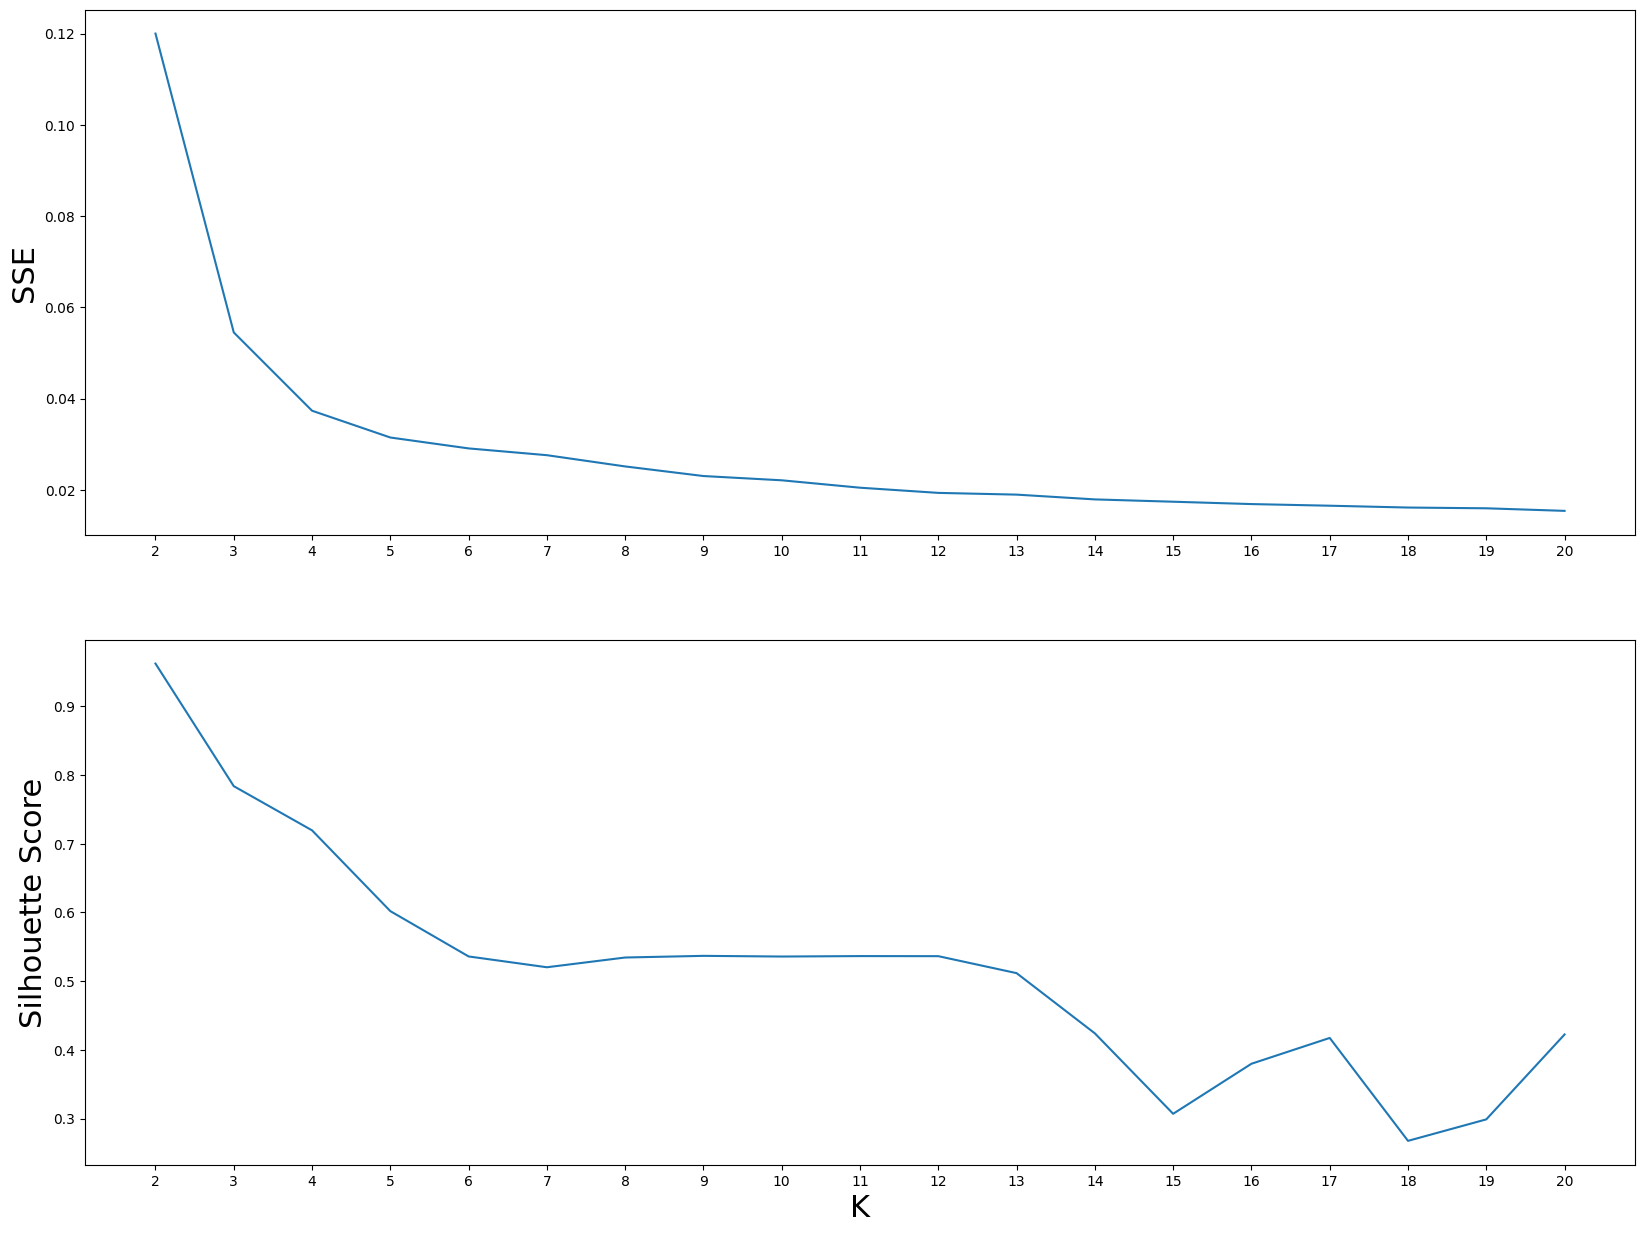

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2),silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))


plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [24]:
CHOSEN_K = 4

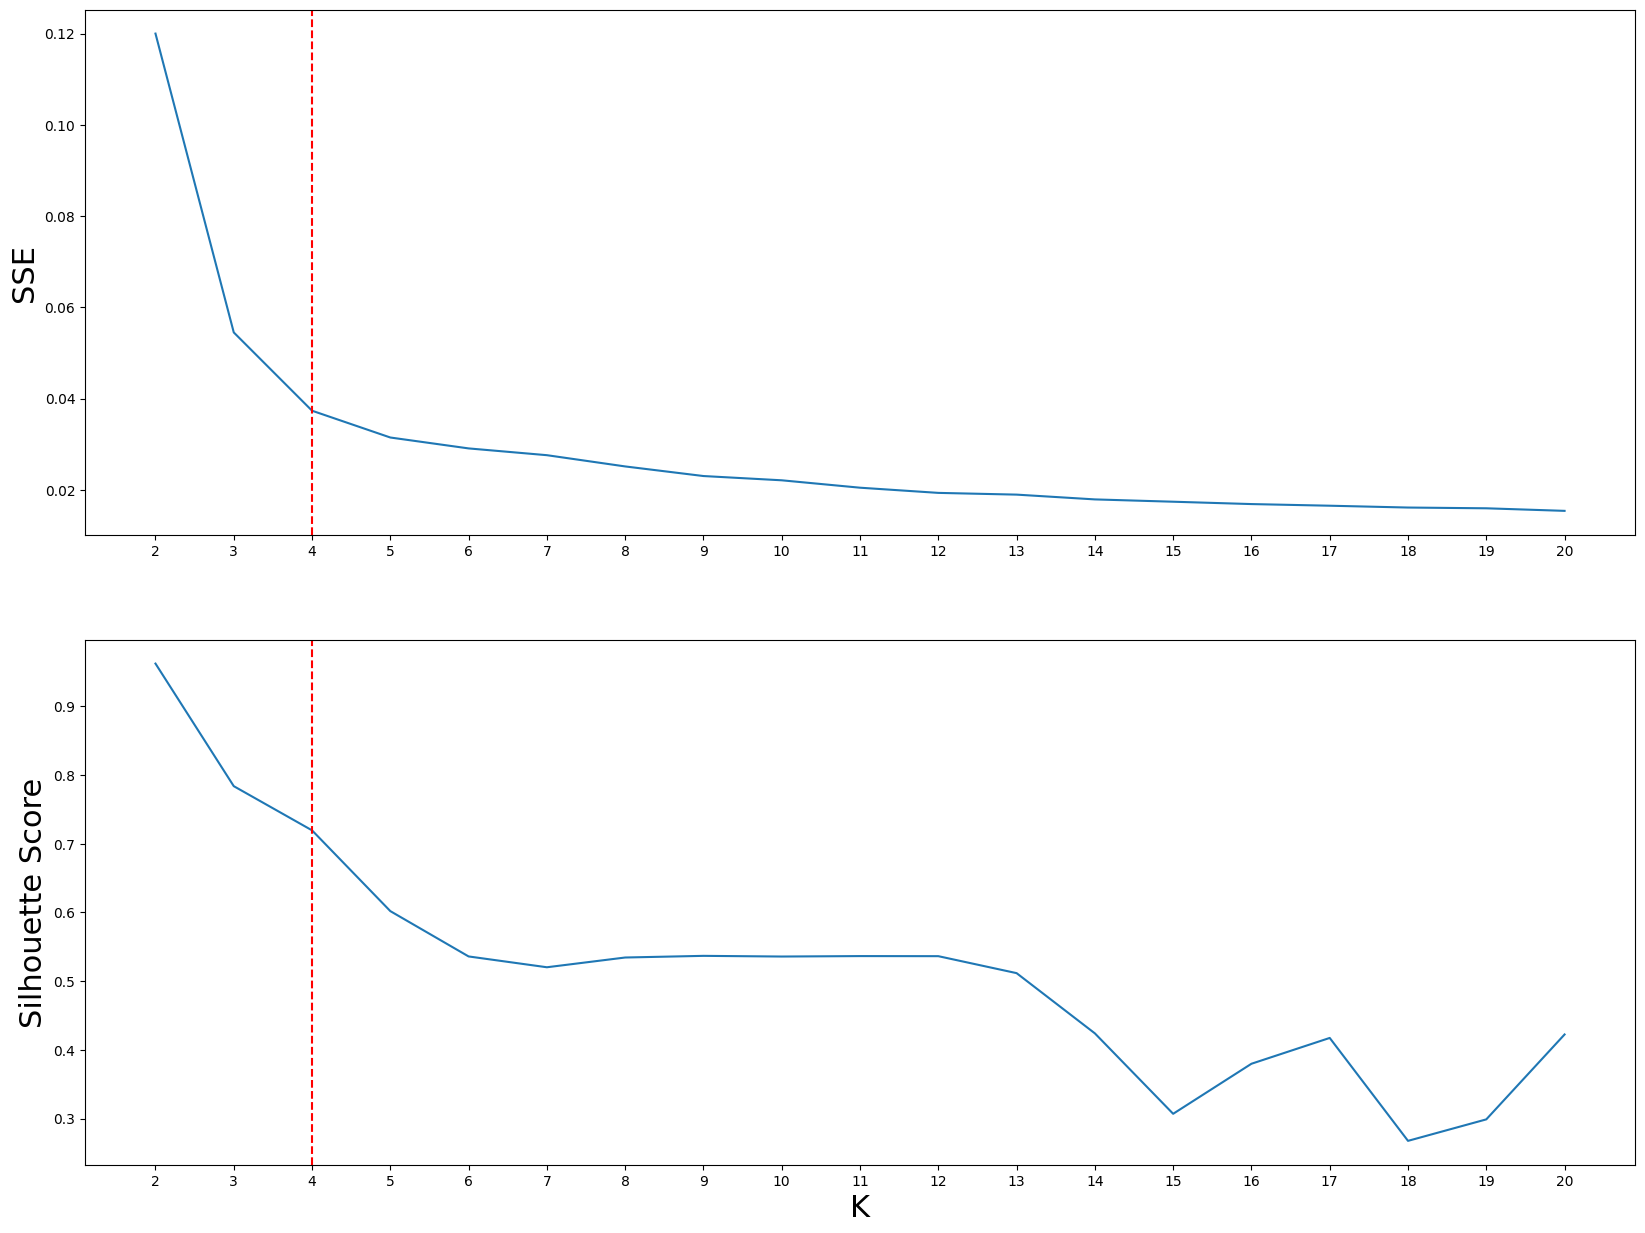

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km) + 2), sse_list_km)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km) + 2))

ax[1].plot(range(2, len(silhouette_list_km) + 2), silhouette_list_km)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [26]:
n_clusters = CHOSEN_K
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=1000, random_state=0, n_init=10)
km.fit(X)

TimeSeriesKMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=0)

In [27]:
km_centers = scaler.inverse_transform(km.cluster_centers_)

Inverse scaling time series with MinMaxScaler


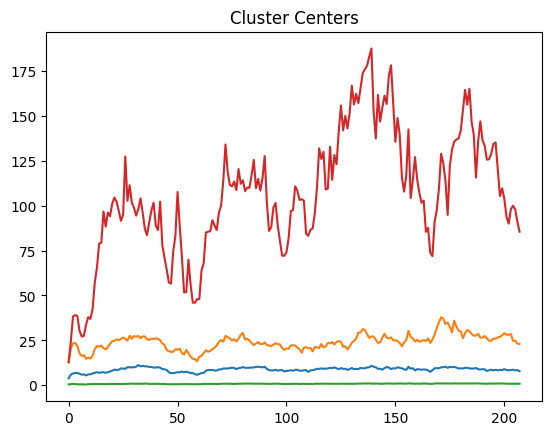

In [28]:
plt.plot(km_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

### 2.1.2 KMeans with DTW

DTW metric requires long computations, as it has complexity asymptotically different from Euclidean distance. Let's explore how much the cost rises.

In [29]:
n_clusters = 3

In [36]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))


Time elapsed for DTW clustering: 571.805 s
Time elapsed for DTW silhouette score: 120.487 s
Number of iterations during training: 13
Total time elapsed for DTW clustering and silhouette score: 692.293 s


This algorithm is much slower than the Euclidean metric version. This is to be expected, as computing Euclidean distance is linear complexity in time, whilst DTW isn't.
 
<b>Let's try with some constraints on DTW!</b>

In [37]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="dtw")
print("Time elapsed for DTW silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

Time elapsed for constrained DTW clustering: 227.454 s
Time elapsed for DTW silhouette score: 77.622 s
Number of iterations during training: 12
Total time elapsed for DTW clustering and silhouette score: 305.076 s


We notice that even though constraining dtw helps a lot, aanother expensive part is calculating the silhouette score with dtw. So let's use euclidean distance as a metric in silhouette score even when using dtw for clustering. It is still a valid choice for evaluating the clustering.

In [38]:
time_init = time.time()
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)
checkpoint = time.time()
print("Time elapsed for constrained DTW clustering: %.3f s" % (time.time() - time_init))
silhouette_km_dtw = ts_silhouette_score(X, km_dtw.labels_, metric="euclidean")
print("Time elapsed for Euclidean silhouette score: %.3f s" % (time.time() - checkpoint))
print("Number of iterations during training: %d" % km_dtw.n_iter_)
print("Total time elapsed for DTW clustering and silhouette score: %.3f s" % (time.time() - time_init))

Time elapsed for constrained DTW clustering: 222.293 s
Time elapsed for Euclidean silhouette score: 0.100 s
Number of iterations during training: 12
Total time elapsed for DTW clustering and silhouette score: 222.394 s


Now that we have brought down the time complexity, let's actually run the search for k. Keep max_k = 10 to avoid computing for too long.

In [39]:
max_k = 10 

sse_list_km_dtw = []
silhouette_list_km_dtw = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
    km_dtw.fit(X)

    if km_dtw._iter == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_dtw.append(km_dtw.inertia_)        
    silhouette_list_km_dtw.append(ts_silhouette_score(X, km_dtw.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 189.574 s
Finished clustering for k = 3; time elapsed: 217.910 s
Finished clustering for k = 4; time elapsed: 228.044 s
Finished clustering for k = 5; time elapsed: 222.204 s
Finished clustering for k = 6; time elapsed: 252.762 s
Finished clustering for k = 7; time elapsed: 287.744 s
Finished clustering for k = 8; time elapsed: 292.527 s
Finished clustering for k = 9; time elapsed: 304.938 s
Finished clustering for k = 10; time elapsed: 300.749 s


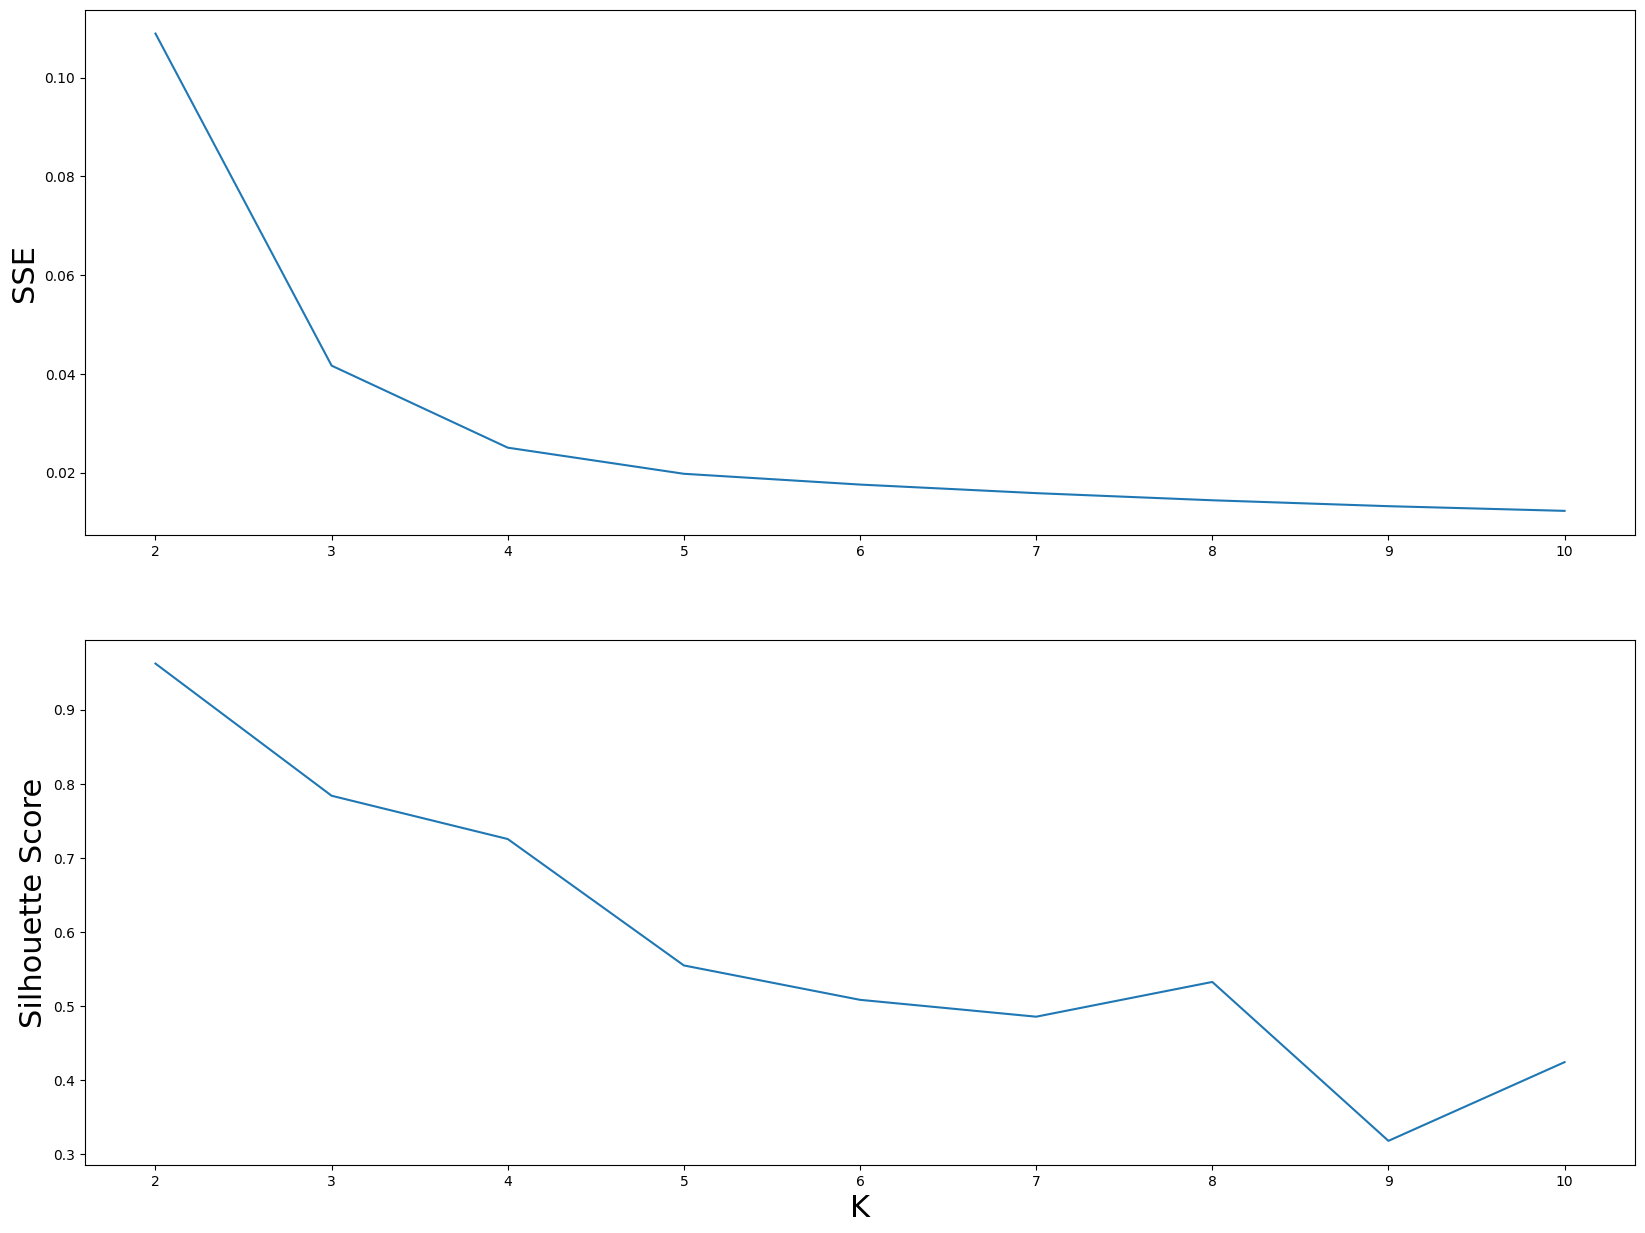

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [41]:
CHOSEN_K = 4

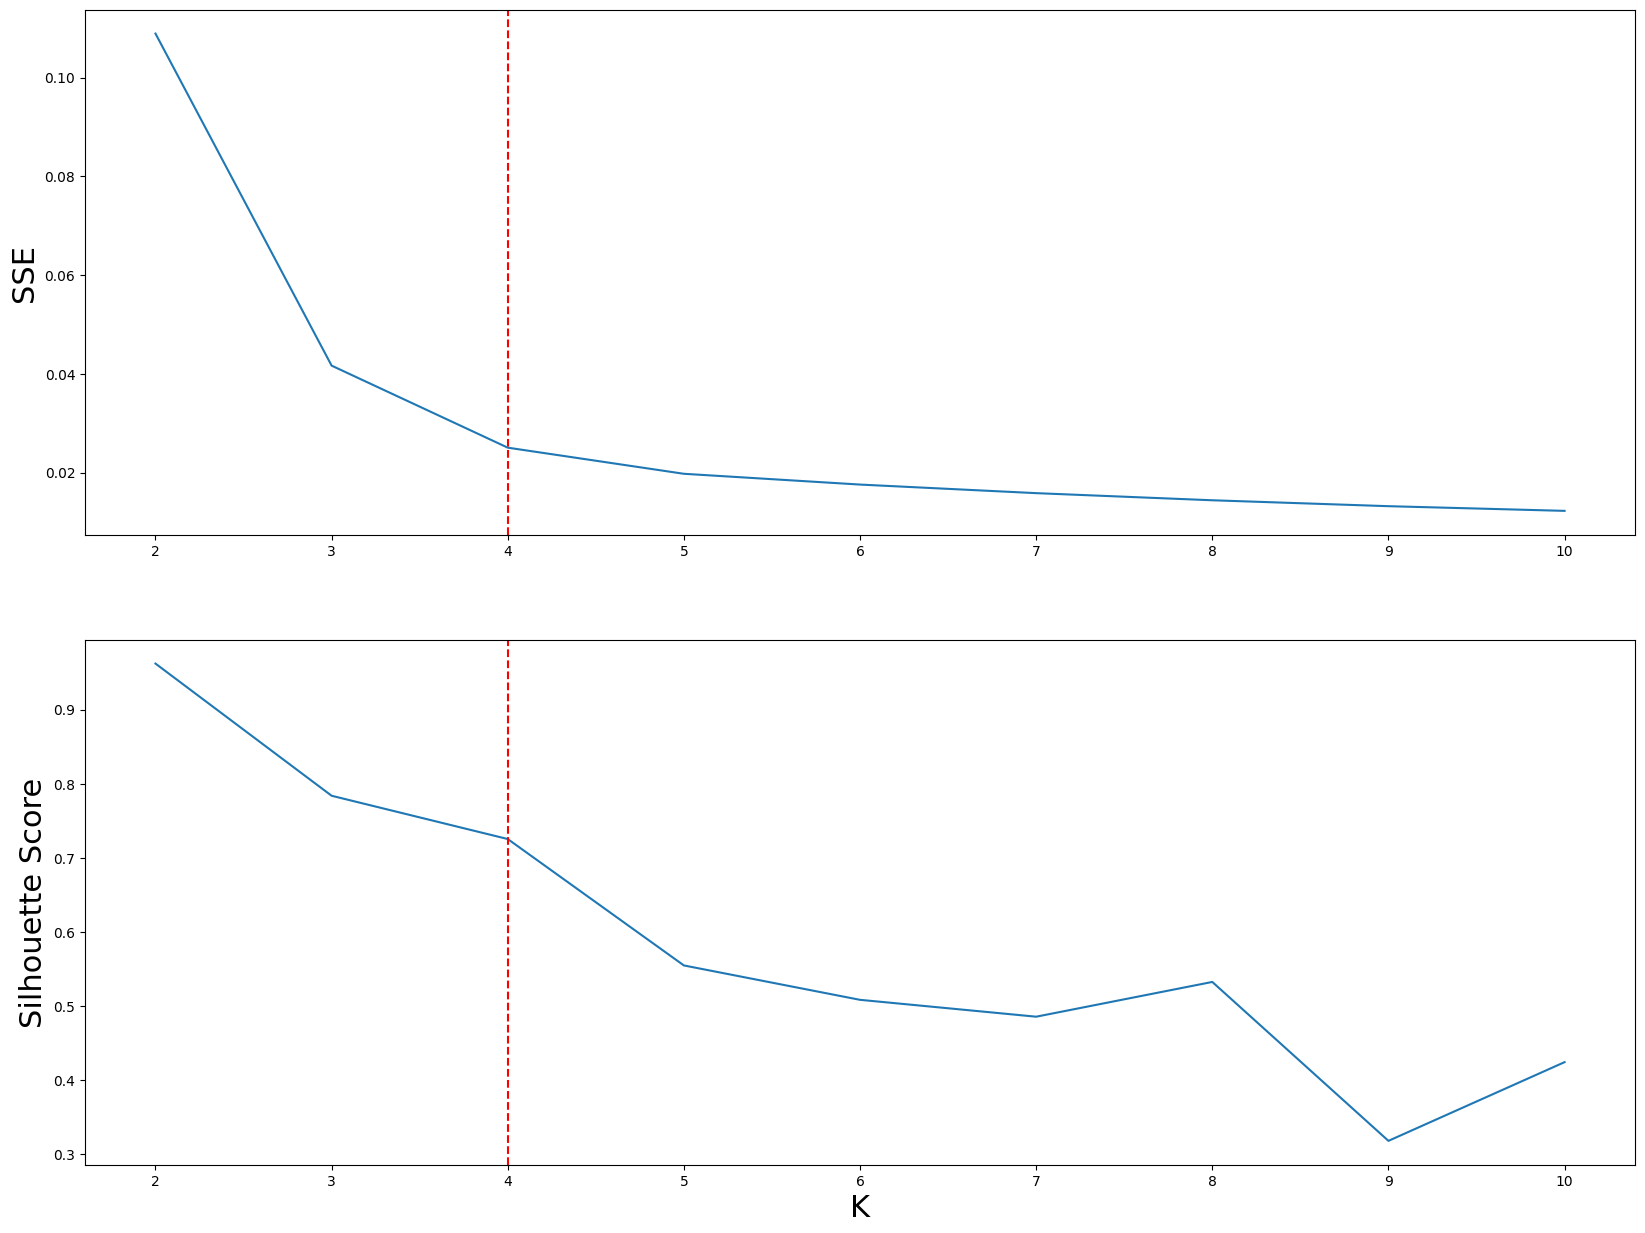

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_dtw) + 2), sse_list_km_dtw)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_dtw) + 2))

ax[1].plot(range(2, len(silhouette_list_km_dtw) + 2), silhouette_list_km_dtw)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_dtw) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [43]:
n_clusters = CHOSEN_K
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=100, random_state=0, \
                          metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 3}, n_init=10)
km_dtw.fit(X)

TimeSeriesKMeans(max_iter=100, metric='dtw',
                 metric_params={'global_constraint': 'sakoe_chiba',
                                'sakoe_chiba_radius': 3},
                 n_clusters=4, n_init=10, random_state=0)

In [44]:
km_dtw_centers = scaler.inverse_transform(km_dtw.cluster_centers_)

Inverse scaling time series with MinMaxScaler


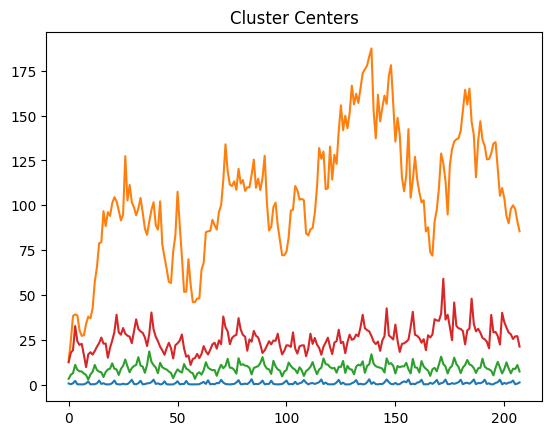

In [45]:
plt.plot(km_dtw_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

In [47]:
# Inertia of the three algorithms
print("Inertia of the two algorithms:")
print("Euclidean k-means:", km.inertia_)
print("DTW k-means:", km_dtw.inertia_)

Inertia of the two algorithms:
Euclidean k-means: 0.03734466600229292
DTW k-means: 0.025067475267093953


## 2.2 Feature-based Clustering

In [48]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import Isomap, TSNE

In [49]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [50]:
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [51]:
F = [list(calculate_features(x).values())[:-2] for x in X]
F = np.array(F)


In [52]:
# repeat code for kmeans, only using features as metric
sse_list_km_features = []
silhouette_list_km_features = []

for k in range(2, max_k + 1):   
    time_init = time.time()

    km_features = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    km_features.fit(F)

    if km_features.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_features.append(km_features.inertia_)        
    silhouette_list_km_features.append(silhouette_score(X, km_features.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Finished clustering for k = 2; time elapsed: 0.165 s
Finished clustering for k = 3; time elapsed: 0.036 s
Finished clustering for k = 4; time elapsed: 0.048 s
Finished clustering for k = 5; time elapsed: 0.046 s
Finished clustering for k = 6; time elapsed: 0.046 s
Finished clustering for k = 7; time elapsed: 0.046 s
Finished clustering for k = 8; time elapsed: 0.045 s
Finished clustering for k = 9; time elapsed: 0.045 s
Finished clustering for k = 10; time elapsed: 0.045 s


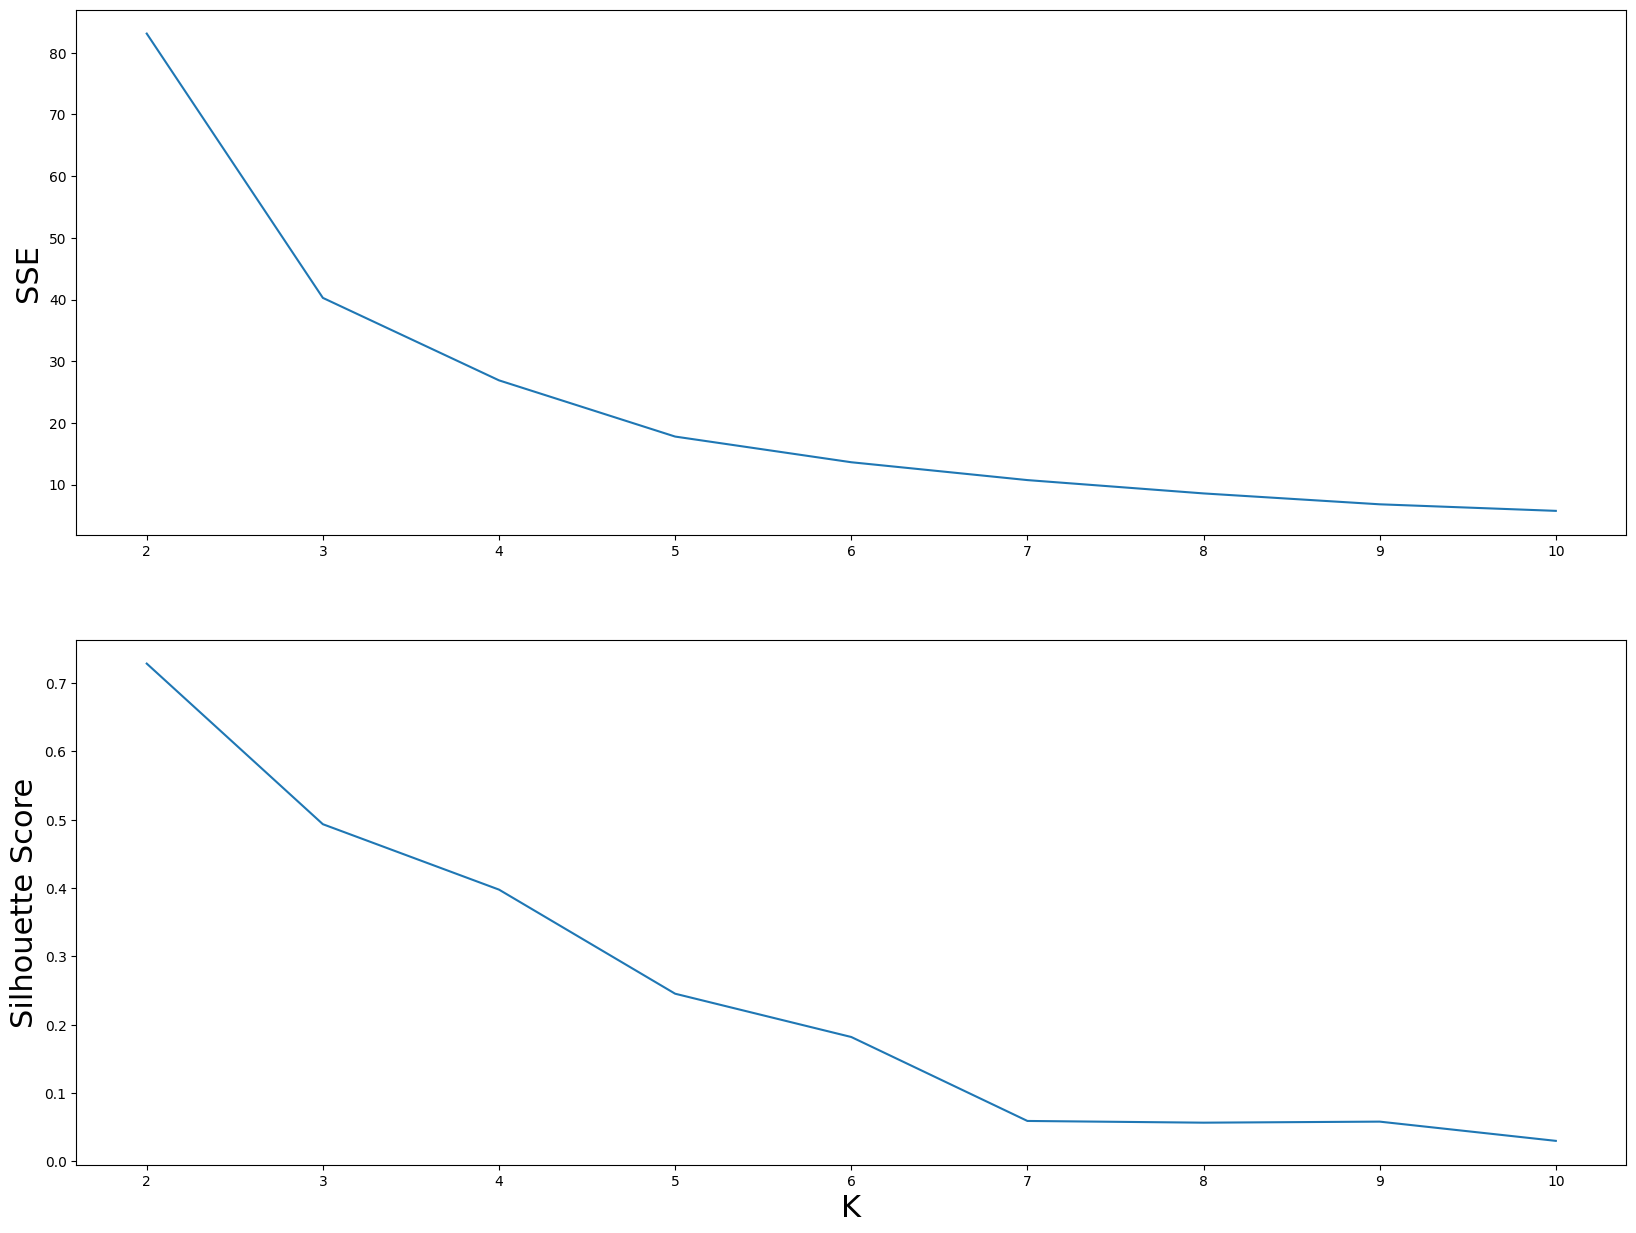

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [642]:
CHOSEN_K = 2

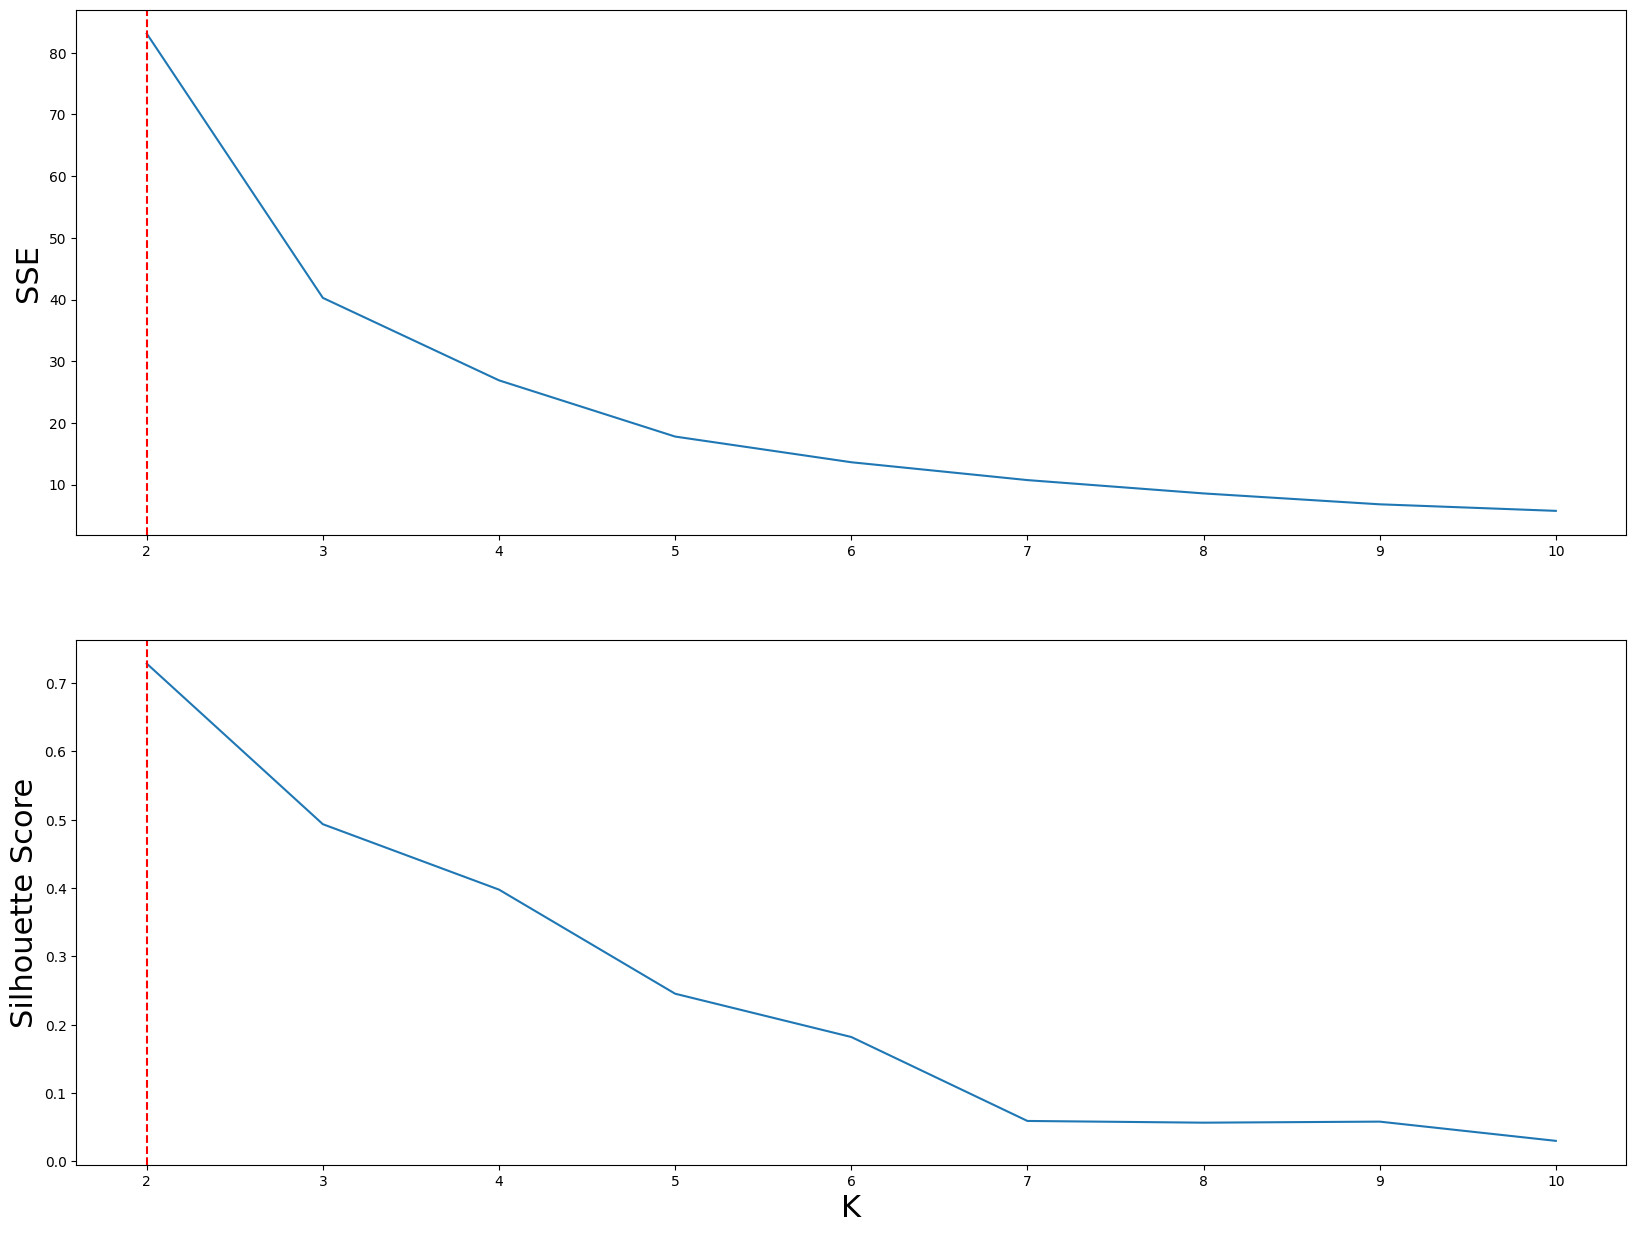

In [643]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_features) + 2), sse_list_km_features)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_features) + 2))

ax[1].plot(range(2, len(silhouette_list_km_features) + 2), silhouette_list_km_features)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_features) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [644]:
n_clusters = CHOSEN_K
km_features = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
km_features.fit(F)

KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=0)

In [645]:
import scipy.sparse as sp

In [649]:
# Make an isomap representation of the datapoints and cluster centers

F_sparse = sp.csr_matrix(F)
F_lil = F_sparse.tolil()

iso = Isomap(n_components=2, n_neighbors=5, n_jobs=-1) 
iso.fit(F_lil)
X_iso = iso.transform(F_lil)
centers_iso = iso.transform(km_features.cluster_centers_)   

# Concatenate features and cluster centers, as tsne is transductive: there is no transform function to apply to cluster centers.
F_tsne = np.concatenate((F, km_features.cluster_centers_), axis=0)
tsne = TSNE(n_components=2, n_jobs=-1, init='random', perplexity=15)
X_tsne = tsne.fit_transform(F_tsne)
centers_tsne = X_tsne[-n_clusters:]
X_tsne = X_tsne[:-n_clusters]

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


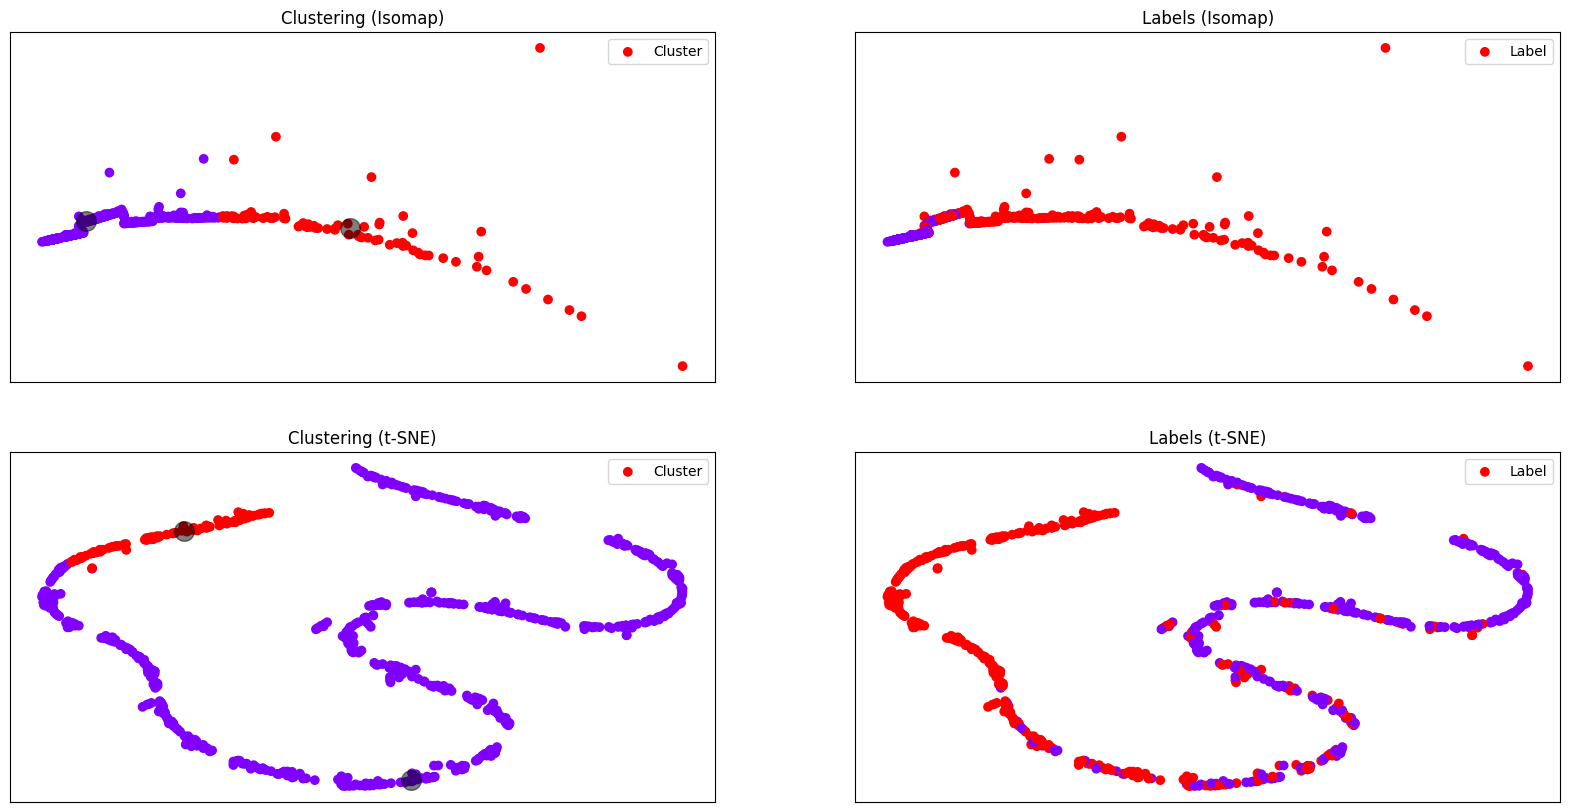

In [650]:
# Do a doubple plot where one is based on clustering and the other is based on the labels
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Isomap - Clustering
scatter_iso_clustering = ax[0, 0].scatter(X_iso[:, 0], X_iso[:, 1], c=km_features.labels_, cmap='rainbow', label='Cluster')
ax[0, 0].scatter(centers_iso[:, 0], centers_iso[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[0, 0].set_title('Clustering (Isomap)')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

# Isomap - Labels
scatter_iso_labels = ax[0, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y, cmap='rainbow', label='Label')
ax[0, 1].set_title('Labels (Isomap)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

# t-SNE - Clustering
scatter_tsne_clustering = ax[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_features.labels_, cmap='rainbow', label='Cluster')
ax[1, 0].scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[1, 0].set_title('Clustering (t-SNE)')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

# t-SNE - Labels
scatter_tsne_labels = ax[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow', label='Label')
ax[1, 1].set_title('Labels (t-SNE)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

# Add Legends
legend_iso_clustering = ax[0, 0].legend(handles=[scatter_iso_clustering], loc='upper right')
legend_iso_labels = ax[0, 1].legend(handles=[scatter_iso_labels], loc='upper right')
legend_tsne_clustering = ax[1, 0].legend(handles=[scatter_tsne_clustering], loc='upper right')
legend_tsne_labels = ax[1, 1].legend(handles=[scatter_tsne_labels], loc='upper right')

plt.show()

In [648]:
print("Inertia of k-means with extracted features:", km_features.inertia_)

Inertia of k-means with extracted features: 83.11752395148473


## 2.3 Compression-based clustering

In [60]:
import zlib

In [61]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [62]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [63]:
# Do some clustering on this compression matrix M
max_k = 20

sse_list_km_comp = []
silhouette_list_km_comp = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km_comp = KMeans(n_clusters=k, max_iter=100, random_state=0, n_init=10)
    km_comp.fit(M)

    if km_comp.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_comp.append(km_comp.inertia_)
    silhouette_list_km_comp.append(silhouette_score(X, km_comp.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))


Finished clustering for k = 2; time elapsed: 0.087 s
Finished clustering for k = 3; time elapsed: 0.098 s
Finished clustering for k = 4; time elapsed: 0.100 s
Finished clustering for k = 5; time elapsed: 0.114 s
Finished clustering for k = 6; time elapsed: 0.113 s
Finished clustering for k = 7; time elapsed: 0.203 s
Finished clustering for k = 8; time elapsed: 0.138 s
Finished clustering for k = 9; time elapsed: 0.165 s
Finished clustering for k = 10; time elapsed: 0.151 s
Finished clustering for k = 11; time elapsed: 0.190 s
Finished clustering for k = 12; time elapsed: 0.158 s
Finished clustering for k = 13; time elapsed: 0.182 s
Finished clustering for k = 14; time elapsed: 0.184 s
Finished clustering for k = 15; time elapsed: 0.186 s
Finished clustering for k = 16; time elapsed: 0.167 s
Finished clustering for k = 17; time elapsed: 0.574 s
Finished clustering for k = 18; time elapsed: 0.190 s
Finished clustering for k = 19; time elapsed: 0.222 s
Finished clustering for k = 20; time

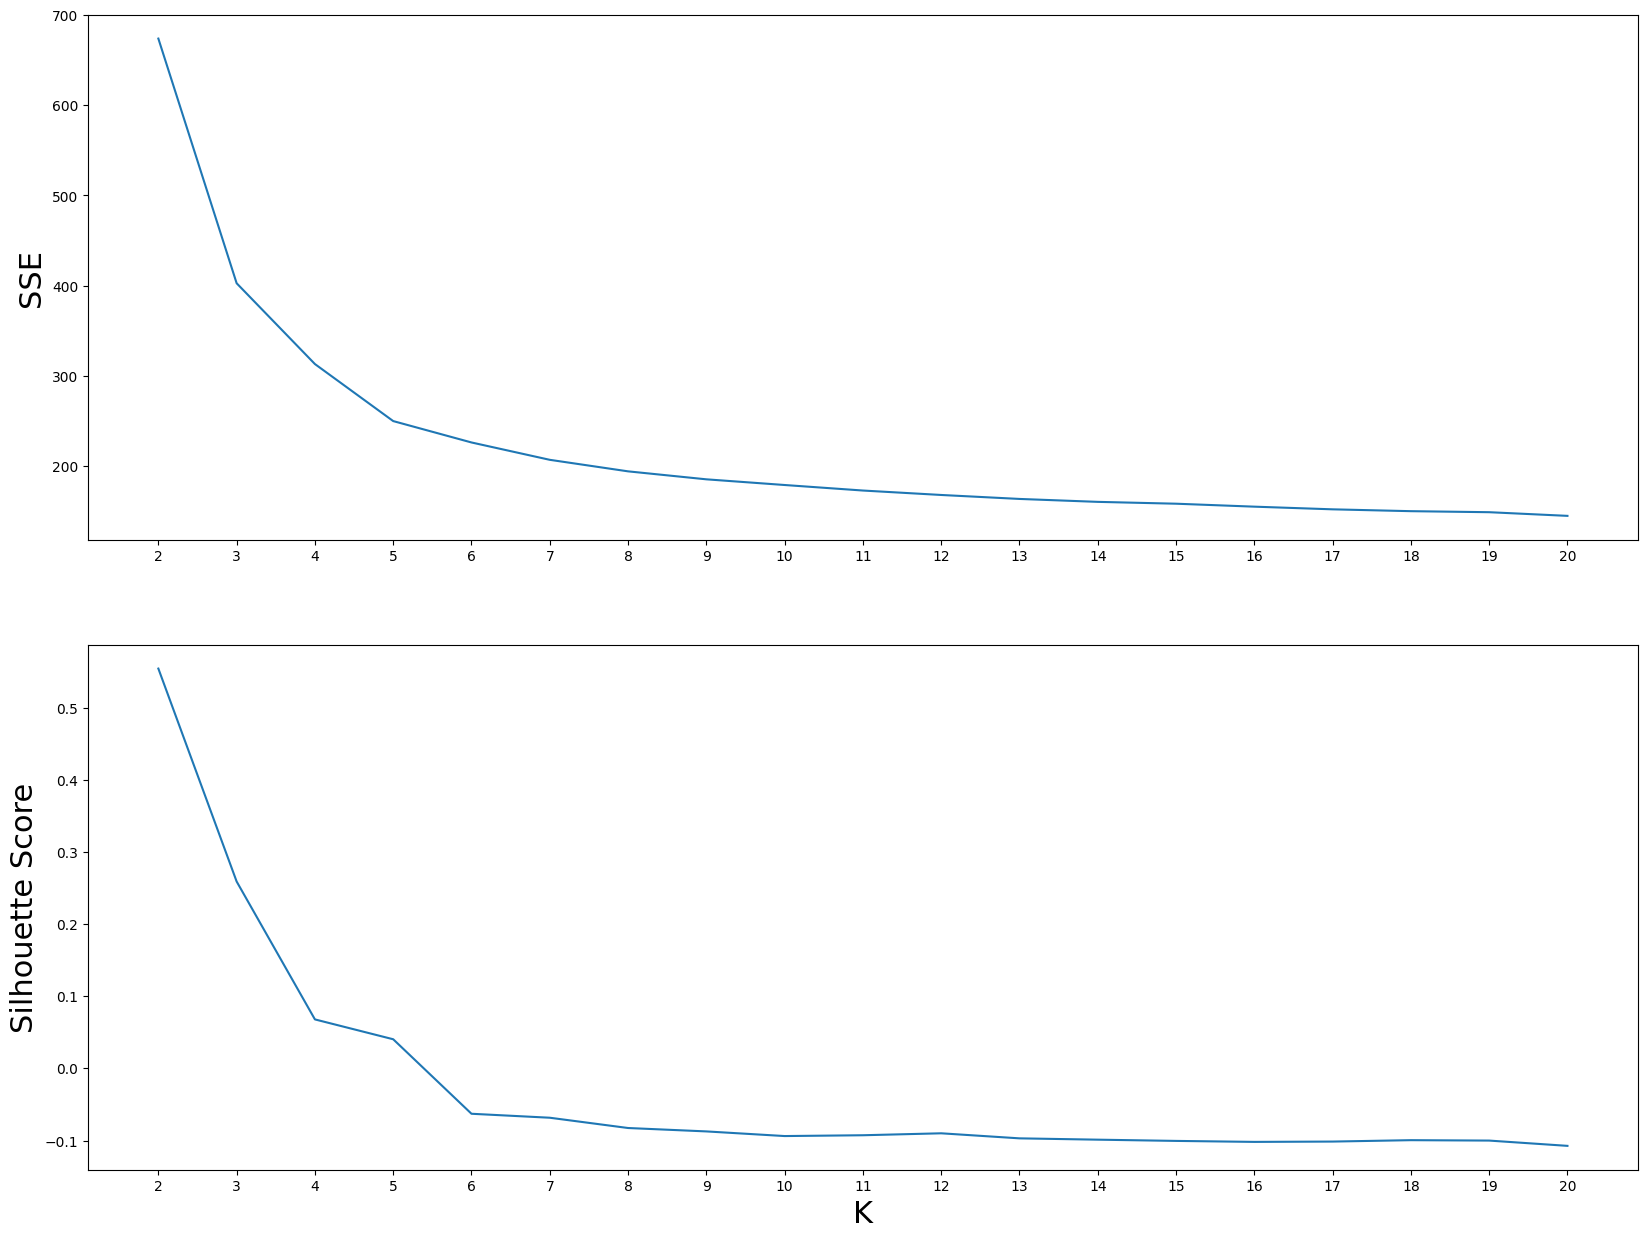

In [64]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_comp) + 2), sse_list_km_comp)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_comp) + 2))

ax[1].plot(range(2, len(silhouette_list_km_comp) + 2), silhouette_list_km_comp)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_comp) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

In [515]:
CHOSEN_K = 2

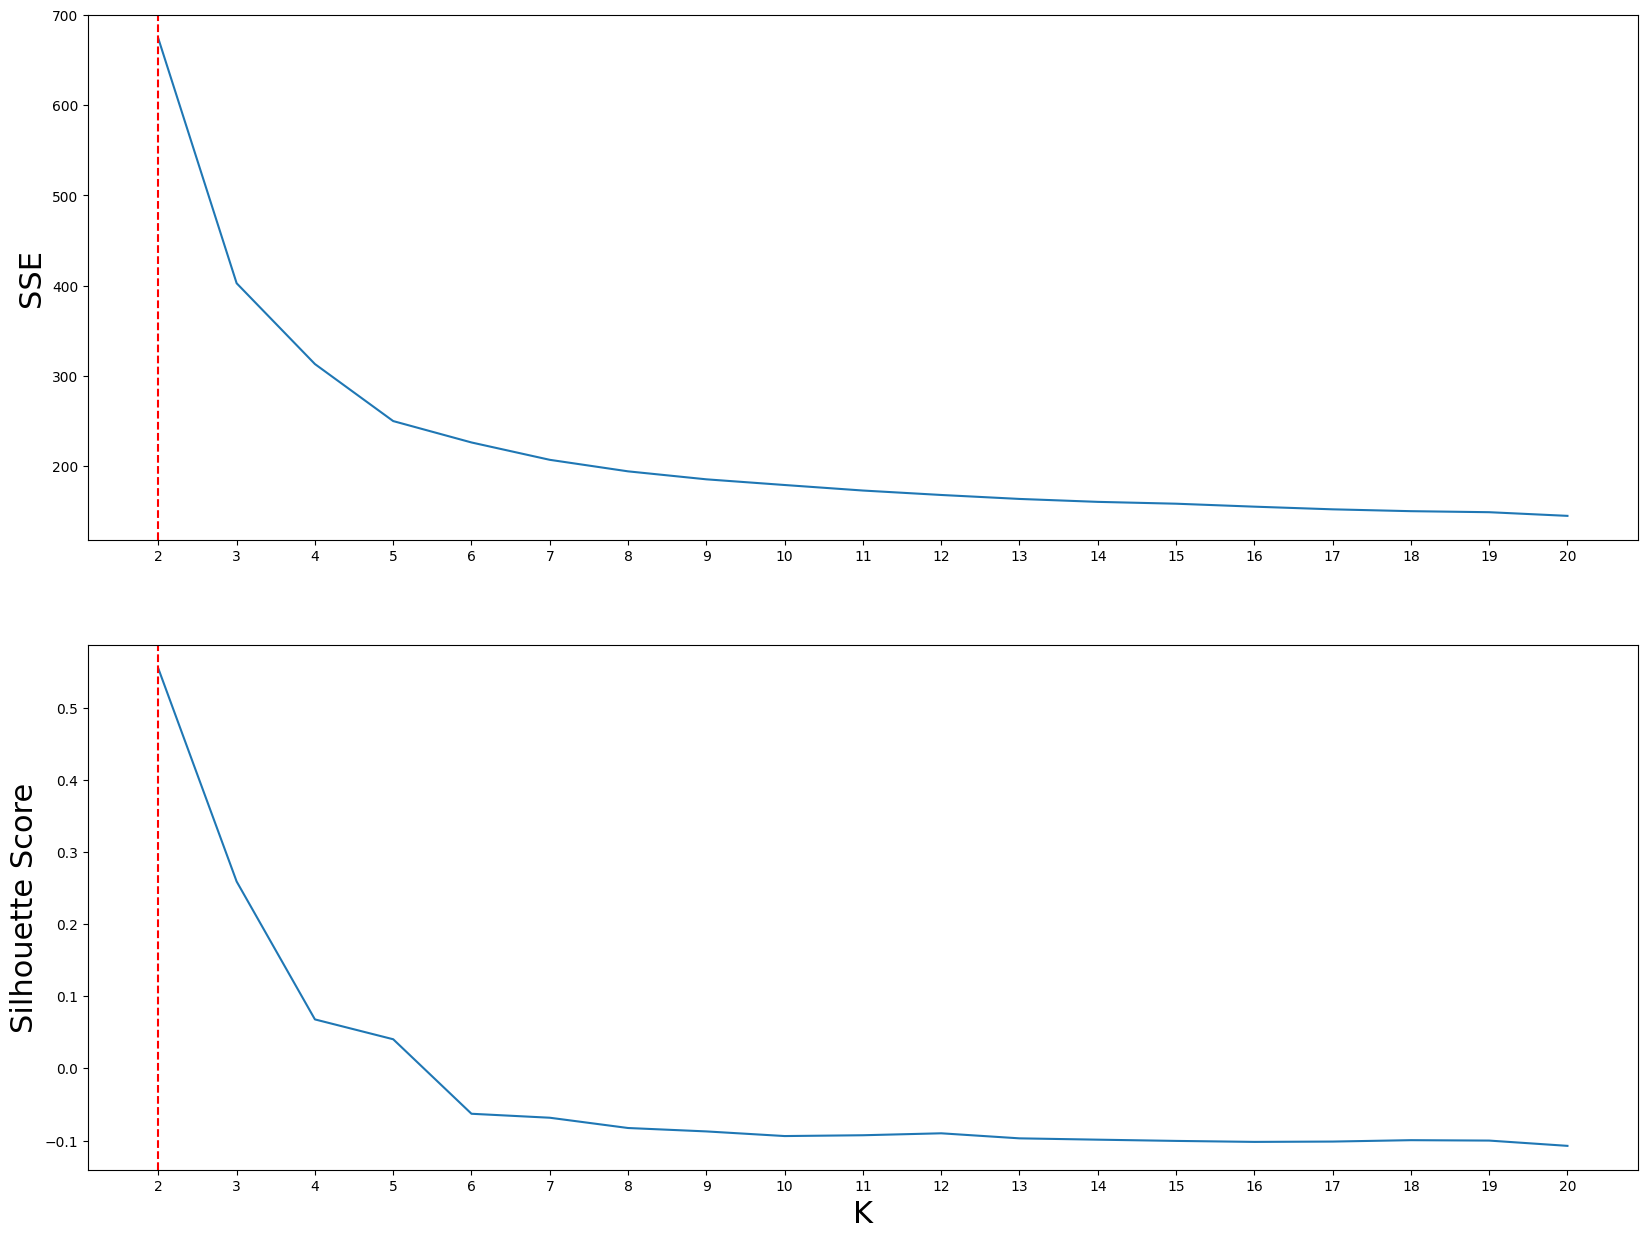

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_comp) + 2), sse_list_km_comp)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_comp) + 2))

ax[1].plot(range(2, len(silhouette_list_km_comp) + 2), silhouette_list_km_comp)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_comp) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [516]:
n_clusters = CHOSEN_K
km_comp = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0, n_init=10)
km_comp.fit(M)

KMeans(max_iter=1000, n_clusters=2, n_init=10, random_state=0)

In [518]:
# Make an isomap representation of the datapoints and cluster centers
M_sparse = sp.csr_matrix(M)
M_lil = M_sparse.tolil()

iso = Isomap(n_components=2, n_neighbors=5, n_jobs=-1) 
iso.fit(M_lil)
X_iso = iso.transform(M_lil)
centers_iso = iso.transform(km_comp.cluster_centers_)   

# Concatenate comp and cluster centers, as tsne is transductive: there is no transform function to apply to cluster centers.
M_tsne = np.concatenate((M, km_comp.cluster_centers_), axis=0)
tsne = TSNE(n_components=2, n_jobs=-1, init='random', perplexity=20)
X_tsne = tsne.fit_transform(M_tsne)
centers_tsne = X_tsne[-n_clusters:]
X_tsne = X_tsne[:-n_clusters]


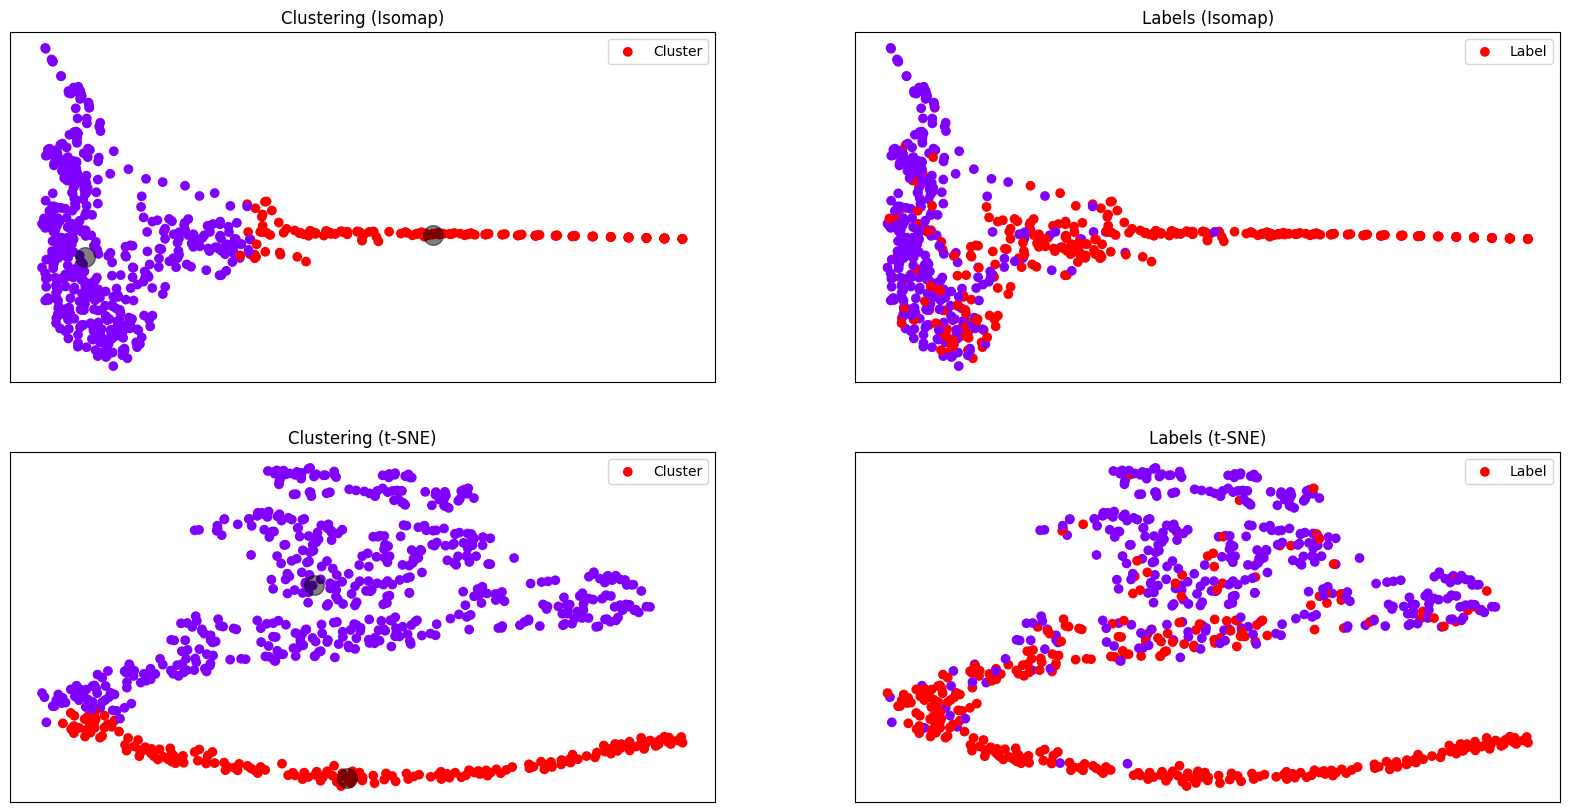

In [519]:
# Switch cluster labels 0 and 1 for plotting better
km_comp.labels_ = np.abs(1 - km_comp.labels_)

# Do a doubple plot where one is based on clustering and the other is based on the labels
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Isomap - Clustering
scatter_iso_clustering = ax[0, 0].scatter(X_iso[:, 0], X_iso[:, 1], c=km_comp.labels_, cmap='rainbow', label='Cluster')
ax[0, 0].scatter(centers_iso[:, 0], centers_iso[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[0, 0].set_title('Clustering (Isomap)')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

# Isomap - Labels
scatter_iso_labels = ax[0, 1].scatter(X_iso[:, 0], X_iso[:, 1], c=y, cmap='rainbow', label='Label')
ax[0, 1].set_title('Labels (Isomap)')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

# t-SNE - Clustering
scatter_tsne_clustering = ax[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=km_comp.labels_, cmap='rainbow', label='Cluster')
ax[1, 0].scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='black', s=200, alpha=0.5, label='Centers')
ax[1, 0].set_title('Clustering (t-SNE)')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

# t-SNE - Labels
scatter_tsne_labels = ax[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='rainbow', label='Label')
ax[1, 1].set_title('Labels (t-SNE)')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

# Add Legends
legend_iso_clustering = ax[0, 0].legend(handles=[scatter_iso_clustering], loc='upper right')
legend_iso_labels = ax[0, 1].legend(handles=[scatter_iso_labels], loc='upper right')
legend_tsne_clustering = ax[1, 0].legend(handles=[scatter_tsne_clustering], loc='upper right')
legend_tsne_labels = ax[1, 1].legend(handles=[scatter_tsne_labels], loc='upper right')

plt.show()

## 2.5 Approximation-based clustering

In [69]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [70]:
n_paa_segments = 20
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.inverse_transform(paa.fit_transform(X))

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 713 1-dimensional timeseries
  warnings.warn(


In [71]:
# repeat code for kmeans

sse_list_km_paa = []
silhouette_list_km_paa = []

for k in range(2, max_k + 1):
    
    time_init = time.time()

    km_paa = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100, random_state=0, n_init=10)
    km_paa.fit(X_paa)

    if km_paa.n_iter_ == 100:
        print("Warning: training did not converge for k = %d." % k)

    sse_list_km_paa.append(km_paa.inertia_)
    silhouette_list_km_paa.append(ts_silhouette_score(X, km_paa.labels_, metric="euclidean"))

    print("Finished clustering for k = %d;" % k, "time elapsed: %.3f s" % (time.time() - time_init))

Finished clustering for k = 2; time elapsed: 3.374 s
Finished clustering for k = 3; time elapsed: 5.717 s
Finished clustering for k = 4; time elapsed: 8.976 s
Finished clustering for k = 5; time elapsed: 5.657 s
Finished clustering for k = 6; time elapsed: 6.031 s
Finished clustering for k = 7; time elapsed: 7.841 s
Finished clustering for k = 8; time elapsed: 5.406 s
Finished clustering for k = 9; time elapsed: 6.101 s
Finished clustering for k = 10; time elapsed: 6.167 s
Finished clustering for k = 11; time elapsed: 6.884 s
Finished clustering for k = 12; time elapsed: 6.053 s
Finished clustering for k = 13; time elapsed: 6.084 s
Finished clustering for k = 14; time elapsed: 6.244 s
Finished clustering for k = 15; time elapsed: 6.739 s
Finished clustering for k = 16; time elapsed: 6.688 s
Finished clustering for k = 17; time elapsed: 6.917 s
Finished clustering for k = 18; time elapsed: 6.309 s
Finished clustering for k = 19; time elapsed: 7.623 s
Finished clustering for k = 20; time

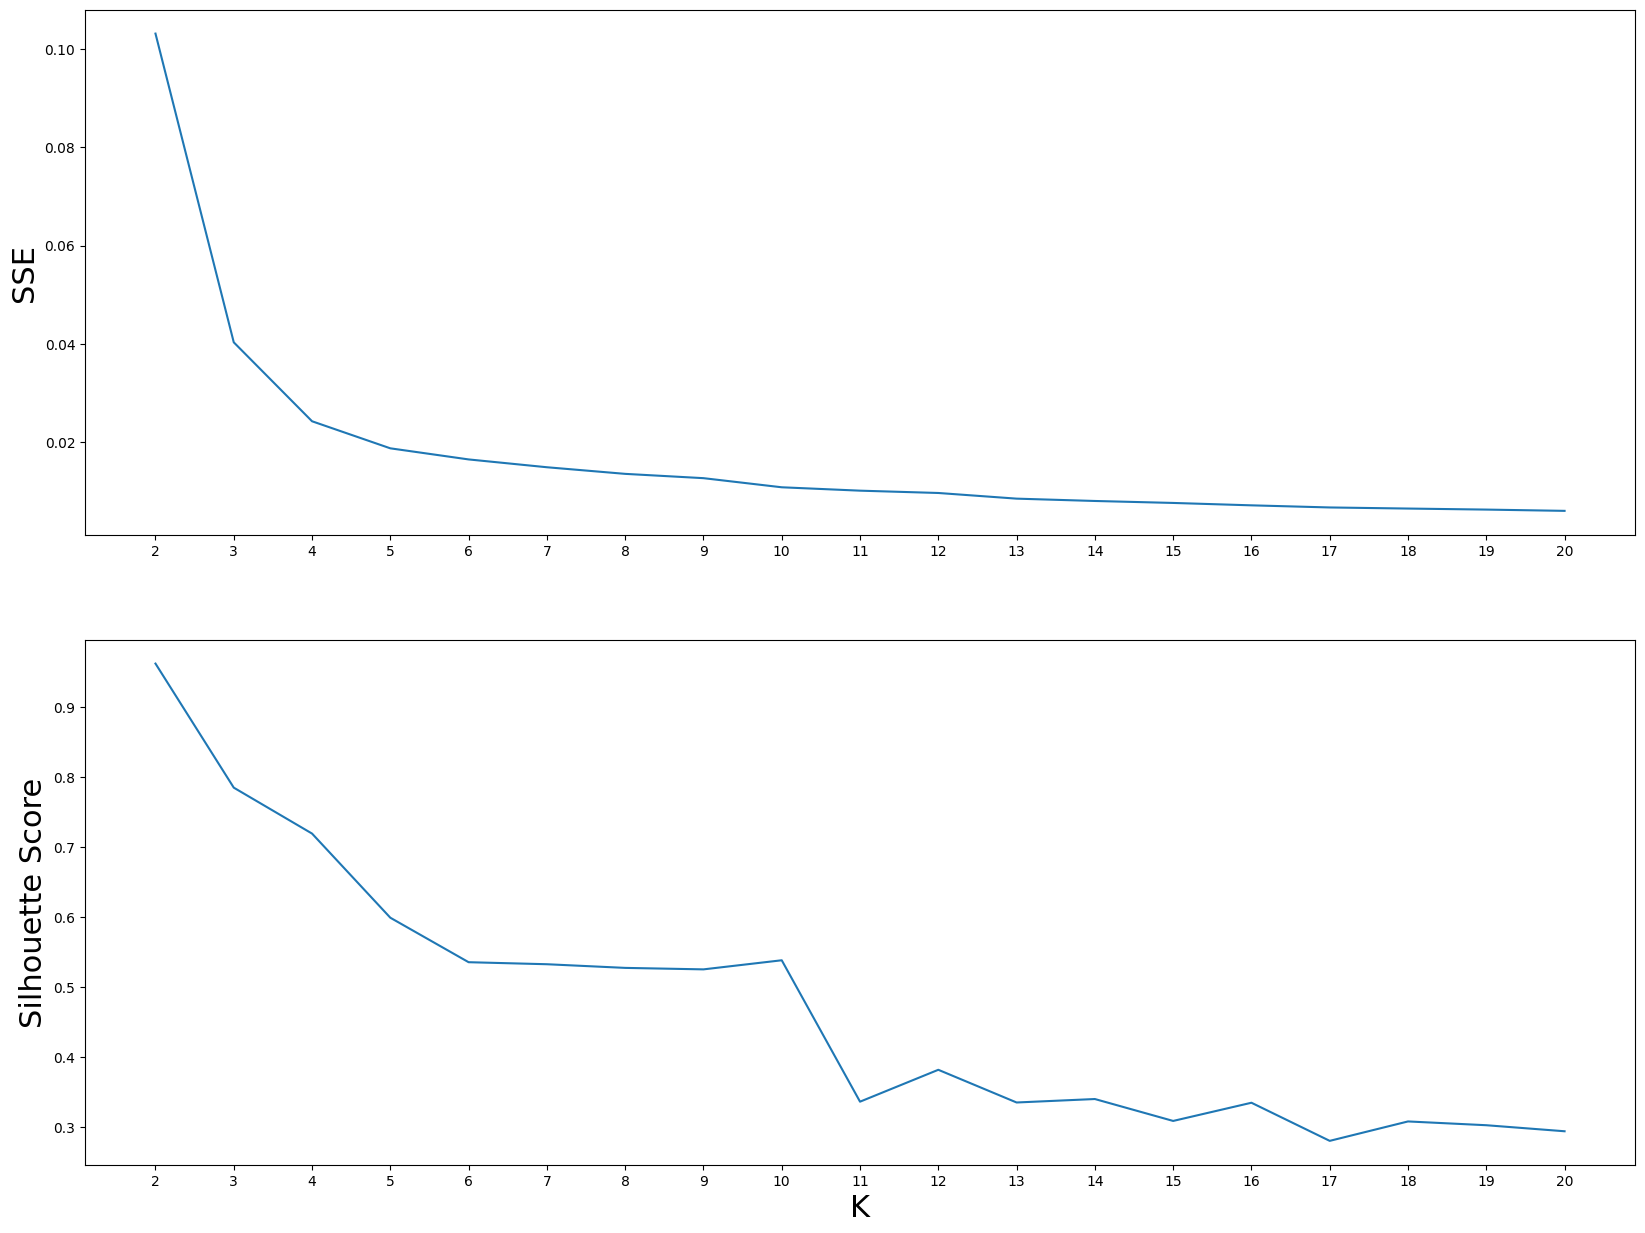

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_paa) + 2), sse_list_km_paa)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_paa) + 2))

ax[1].plot(range(2, len(silhouette_list_km_paa) + 2), silhouette_list_km_paa)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_paa) + 2))

plt.xlabel("K", fontsize=22)
plt.show()

Choose K based on the plots.

In [73]:
CHOSEN_K = 4

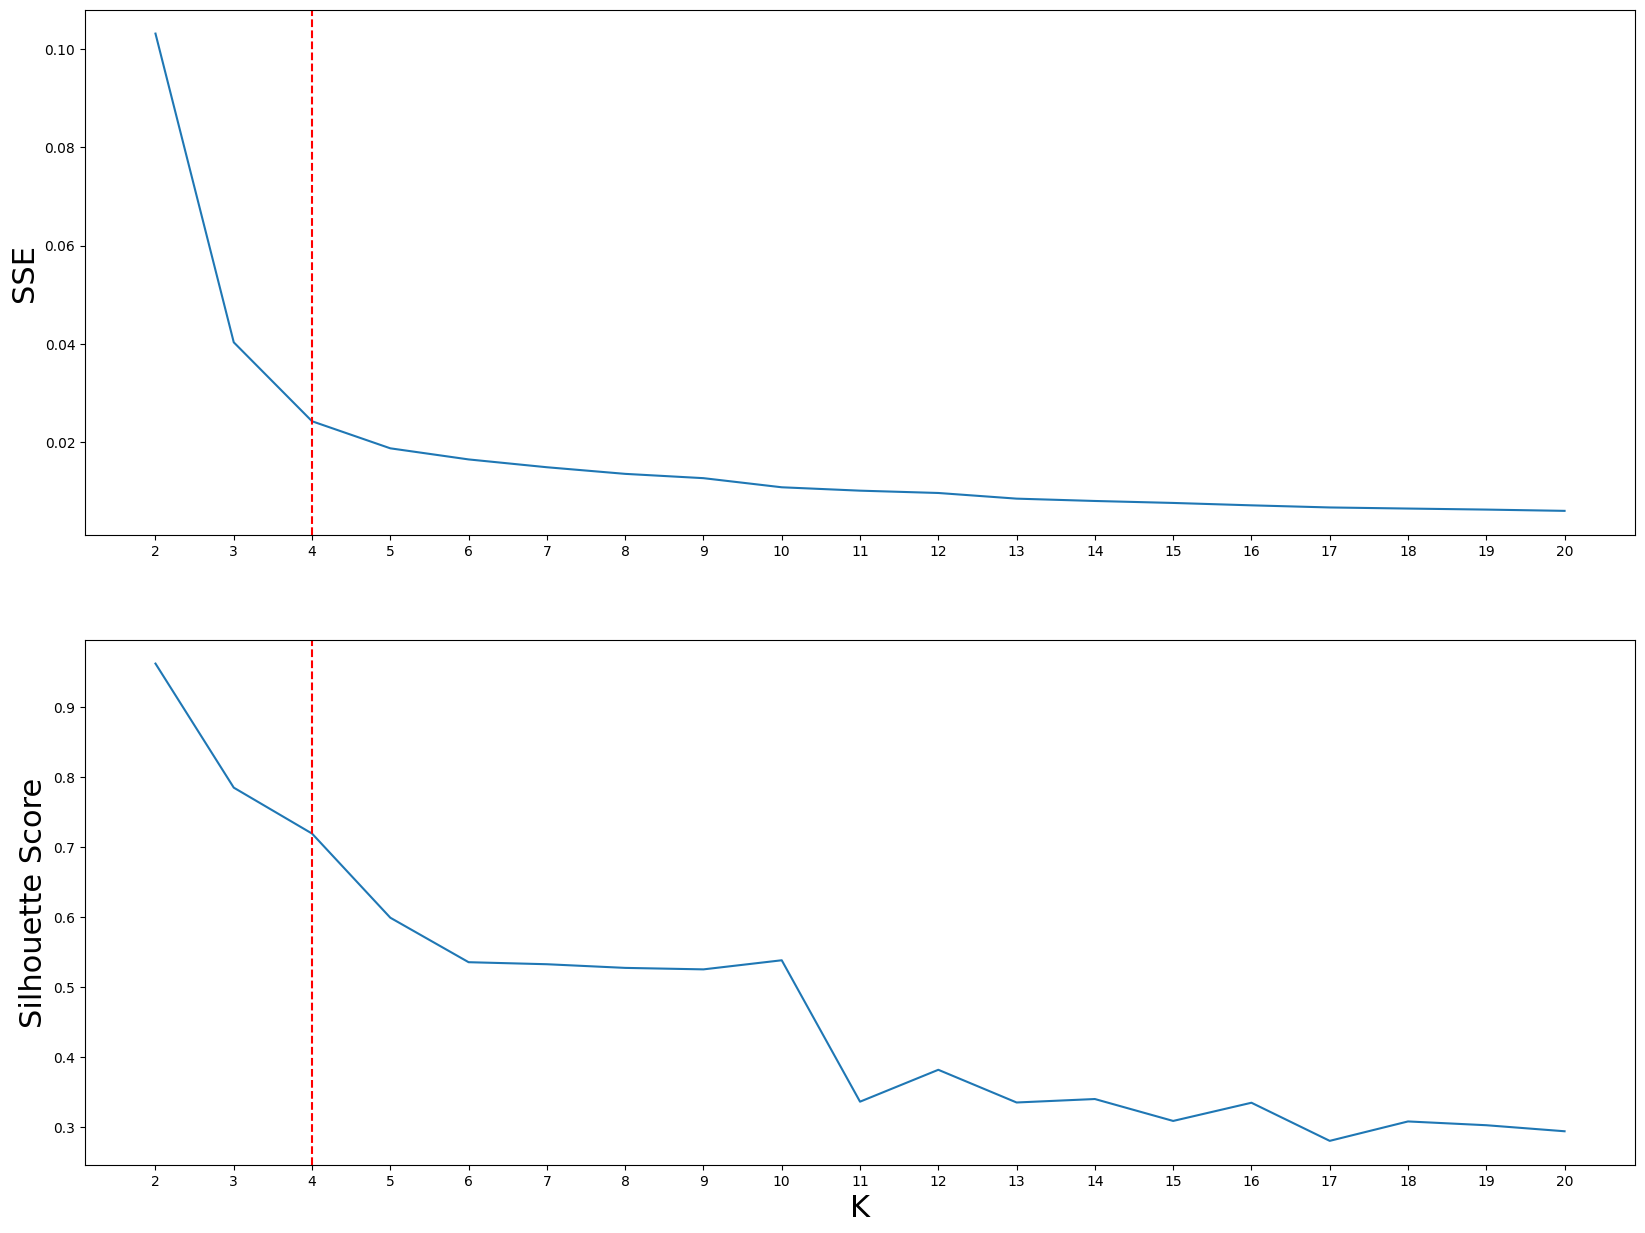

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(range(2, len(sse_list_km_paa) + 2), sse_list_km_paa)
ax[0].set_ylabel("SSE", fontsize=22)
ax[0].set_xticks(range(2, len(sse_list_km_paa) + 2))

ax[1].plot(range(2, len(silhouette_list_km_paa) + 2), silhouette_list_km_paa)
ax[1].set_ylabel("Silhouette Score", fontsize=22)
ax[1].set_xticks(range(2, len(silhouette_list_km_paa) + 2))

# set a vertical line on all three subplots at x = CHOSEN_K
for i in range(2):
    ax[i].axvline(x=CHOSEN_K, color="r", linestyle="--")

plt.xlabel("K", fontsize=22)
plt.show()

In [75]:
n_clusters = CHOSEN_K
km_paa = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=1000, random_state=0, n_init=10)
km_paa.fit(X_paa)

TimeSeriesKMeans(max_iter=1000, n_clusters=4, n_init=10, random_state=0)

In [76]:
km_paa_centers = scaler.inverse_transform(km_paa.cluster_centers_)

Inverse scaling time series with MinMaxScaler


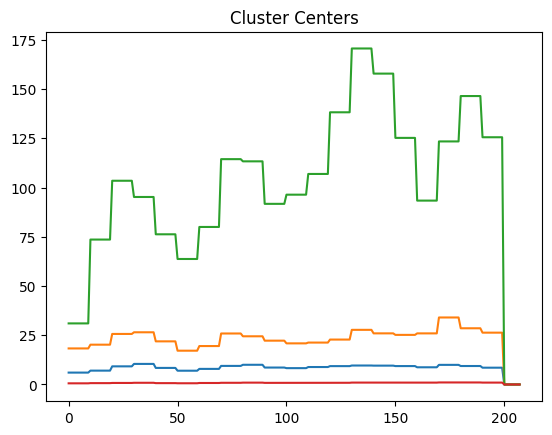

In [77]:
plt.plot(km_paa_centers.reshape(n_clusters, X.shape[1]).T)
plt.title("Cluster Centers")
plt.show()

Recompute the centroid from time series in cluster.

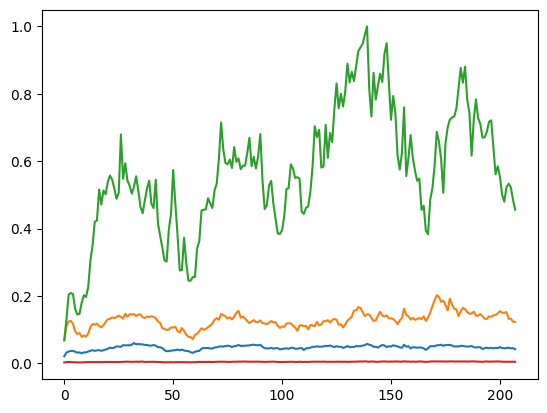

In [78]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(km_paa.labels_ == i)[0]], axis=0))
plt.show()

In [79]:
for i in range(n_clusters):
    print(f'Number of points in cluster {i}: {np.where(km_paa.labels_ == i)[0].shape[0]}')

Number of points in cluster 0: 65
Number of points in cluster 1: 12
Number of points in cluster 2: 1
Number of points in cluster 3: 635


# 3. Motif Extraction

In [80]:
import stumpy

In [81]:
cities.shape

(713,)

In [368]:
city = 'BOSTON'

# Find index of city in the cities array of cities
city_index = np.where(cities == city)

# Get the time series of the city
ts = X[city_index]
ts = ts.reshape(ts.shape[1])


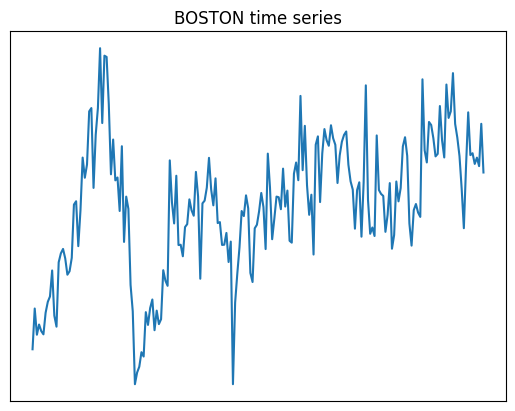

In [369]:
# Plot the time series
plt.plot(ts)
plt.title(f'{city} time series')
plt.xticks([])
plt.yticks([])
plt.show()

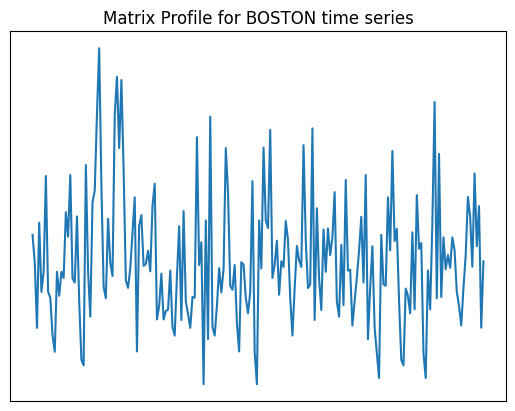

In [382]:
w = 5
mp = stumpy.stump(ts, w)[:, 0]

plt.plot(mp)
plt.xticks([])
plt.yticks([])
plt.title(f'Matrix Profile for {city} time series')
plt.show()

In [383]:
# Find the motifs and their locations
motif_dist, motif_idx = stumpy.motifs(ts, mp, max_motifs=5)

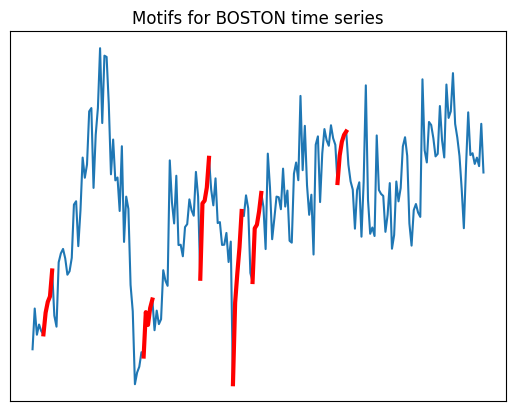

In [384]:
plt.plot(ts)

colors = ['r', 'g', 'k', 'b', 'y'][:len(motif_dist)]

for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
plt.xticks([])
plt.yticks([])
plt.title(f'Motifs for {city} time series')
plt.show()

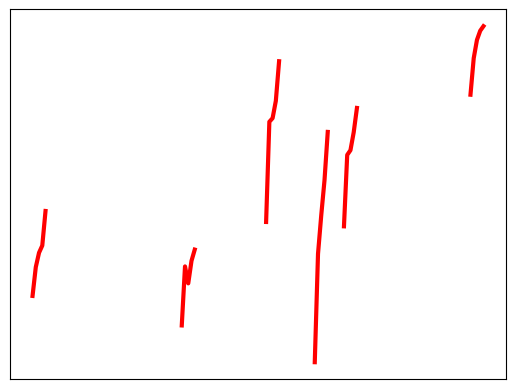

In [385]:
for motifs, indices, color in zip(motif_dist, motif_idx, colors):
    for index in indices:
        motif_shape = ts[index:index + w]
        if len(motif_shape) == w:
            plt.plot(range(index, index + w), motif_shape, color=color, lw=3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 4. Anomaly Detection

Calculate anomalies as out of distribution values of the matrix profile.

In [386]:
# Calculate z-scores for the matrix profile
z_scores = stats.zscore(mp.tolist())

# Define a threshold (e.g., 3 standard deviations)
threshold = 3

# Find anomalies based on the threshold
anomalies = np.where(np.abs(z_scores) > threshold)[0]

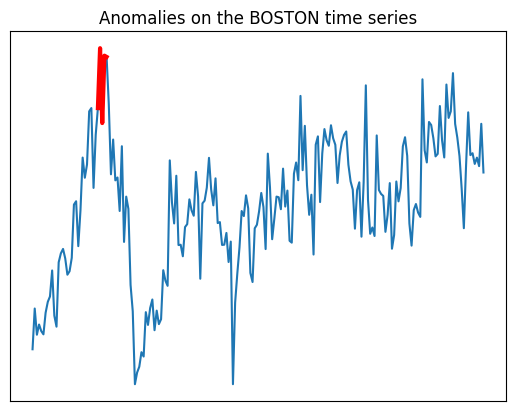

In [387]:
plt.plot(ts)
for a in anomalies:
    a_shape = ts[a:a+w]
    plt.plot(range(a, a+w), a_shape, color='r', lw=3)
plt.xticks([])
plt.yticks([])

plt.title(f'Anomalies on the {city} time series')
plt.show()

# 5. Shapelet Extraction

In [90]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-01-07 18:01:12.836372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 5.1 Dataset preparation with labelling

In the previous tasks, it made more sense to take into account the amplitude of time series (as this information is very important for clustering, motif extraction and anomaly detection for the time series in our setting, because we are using a quantitative score and we're not doing trend analysis or anything like that which would be more shape dependent). In shapelet extraction, however, it is more instructive to perform independent scaling (amplitude scaling) on each time series for actually just focusing on the shape. For this reason, we use another scaler. 

Validating this opinion, we also analyzed the behaviour of the shapelet algorithm with the fixed scaling, and observe a infact signifcantly better performance for classification of the IsKilled variable. This makes sense as the relative amplitude of time series is very important for separating them in the IsKilled(0,1) classes, because the amplitude is tighed to the number of incidents and, thus, likely also to the IsKilled target.

Arguably, this could lead to the simple conclusion that shapelet extraction is not the correct way to go for this classification task, as it focuses more on shape than it does on amplitude, whilst the task at hand values amplitude over shape.

In [578]:
X = X_minmax_independent
scaler = scaler_minmax_independent

In [579]:
# See how many time series in dataset have at least one killing and how many don't
# This is the label for the shapelet learning task
print(f'Number of time series with at least {ISKILLED_THRESHOLD} killings:', np.sum(y))
print('Number of time series with no killings:', y.shape[0] - np.sum(y))

Number of time series with at least 25 killings: 341
Number of time series with no killings: 372


In [580]:
# Split into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## 5.2 Shapelet Discovery

Define the hyperparameters.

In [600]:
# Define hyperparams
n_ts, ts_sz = X_train.shape[:2]
print(n_ts, ts_sz)
l = 0.025
r = 4

570 208


In [601]:
shapelet_dict = grabocka_params_to_shapelet_size_dict(n_ts = n_ts, ts_sz = ts_sz, n_classes = 2, l = l, r = r)
shapelet_dict

{5: 5, 10: 5, 15: 5, 20: 5}

Generate shapelets on the small training set and then use those shapelets for doing the shapelet transform on all setes: the full training set, the validation set and the test set. We will then use these resulting shapelet-transformed sets to train the classifier.

In [602]:
trans = LearningShapelets(n_shapelets_per_size= shapelet_dict, weight_regularizer=0.001, batch_size=64, max_iter=2500,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), scale=False)

# Fit the model
trans.fit(X_train, y_train)
shapelets_learned = trans.shapelets_
shapelets_learned_as_ts = trans.shapelets_as_time_series_

X_train_sh = trans.transform(X_train)
X_test_sh = trans.transform(X_test)

print('Shapelet transform performed, returning array of shape=(n_ts, n_shapelets) of distances to each shapelet')
print(X_train_sh.shape)
print(X_test_sh.shape)
print('Number of shapelets according to the shapelet dictionary:', sum(shapelet_dict.values()))
print('Actual number of shapelets learned:', shapelets_learned.shape[0])

/Users/dre/Desktop/GitRepo/Others/DataMiningProject/venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet transform performed, returning array of shape=(n_ts, n_shapelets) of distances to each shapelet
(570, 20)
(143, 20)
Number of shapelets according to the shapelet dictionary: 20
Actual number of shapelets learned: 20


In [603]:
y_pred = trans.predict(X_test)
accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
print('Test accuracy:', accuracy)

Test accuracy: 0.7832167832167832


In [604]:
print('Shape of shapelets learned as time series:', shapelets_learned_as_ts.shape)
print('Shape of shapelets learned:', shapelets_learned.shape)  

Shape of shapelets learned as time series: (20, 20, 1)
Shape of shapelets learned: (20,)


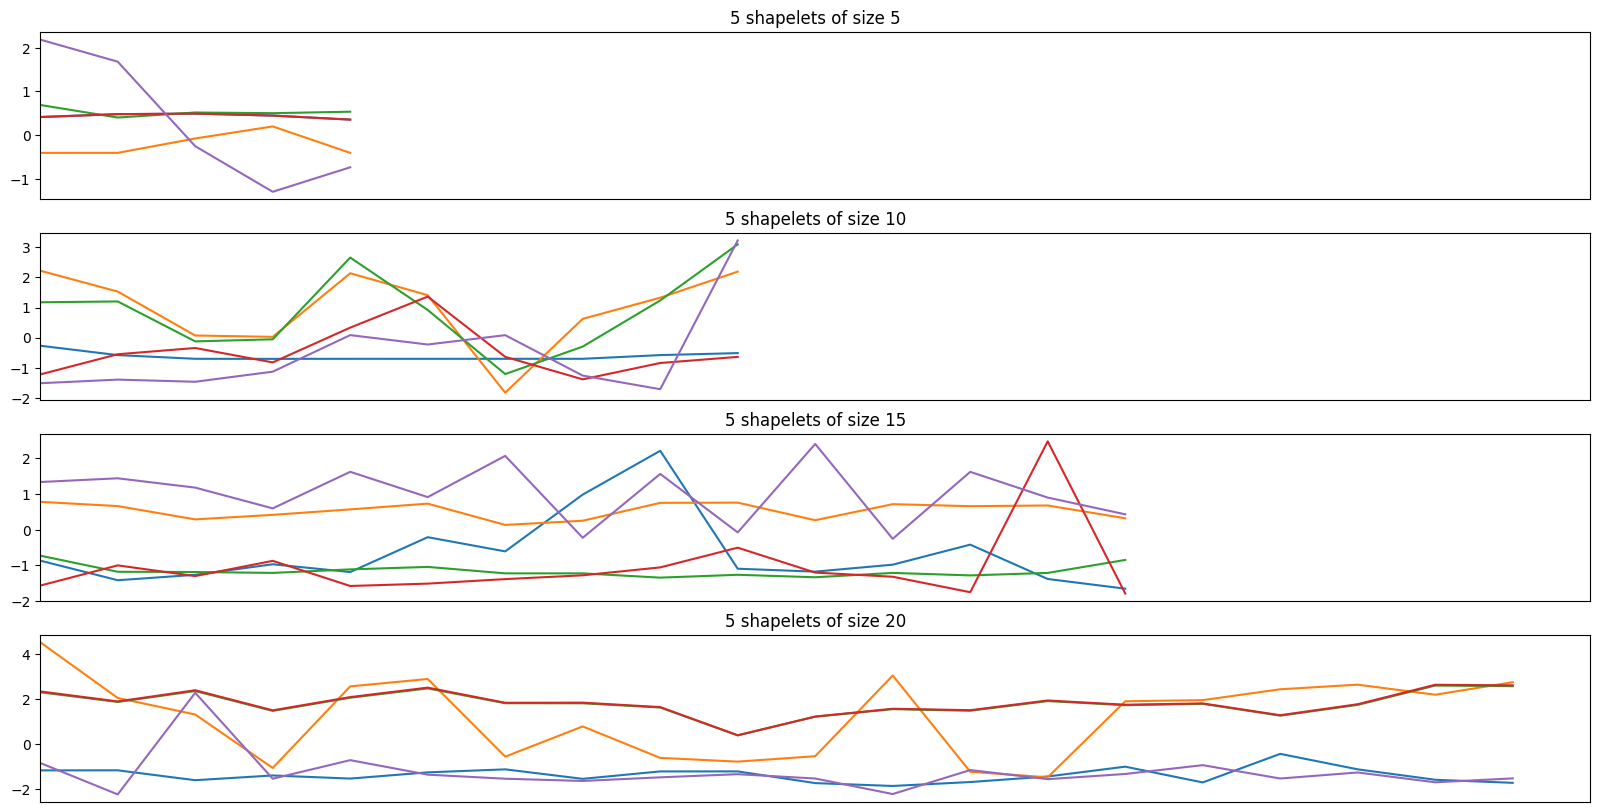

In [605]:
# Show the shapelets that are as many as we calculated in the dictionary
n_shapelet_sizes = len(shapelet_dict.keys())
max_shapelet_size = max(shapelet_dict.keys())

plt.figure(figsize=(20, 10))
for i, sz in enumerate(shapelet_dict.keys()):
    plt.subplot(n_shapelet_sizes, 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_dict[sz], sz))
    for sh_idx in range(shapelet_dict[sz]):
        plt.plot(shapelets_learned_as_ts[sh_idx + sum(list(shapelet_dict.values())[:i])].ravel())
        plt.xlim([0, max_shapelet_size])
        plt.xticks([])

As explained in the paper, multiple similar shapelets is not necessarily a bad thing. In ML, generally, having two similar features might cause multicollinearity and bias, but in the case of shapelets, one shapelet might not be able to separate the data, so multiple similar shapelets may be actually useful.

Paper: https://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## 5.3 Classification with Shapelets

In [606]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint as sp_randint

### 5.3.1 K-nn

In [607]:
knn = KNeighborsClassifier(algorithm='ball_tree', metric='minkowski')
param_dist = {"n_neighbors": [1, 3, 5, 10, 20]}

grid_search = GridSearchCV(knn, param_grid=param_dist,
                                 n_jobs=-1,
                                 scoring='accuracy')

grid_search.fit(X_train_sh, y_train)

GridSearchCV(estimator=KNeighborsClassifier(algorithm='ball_tree'), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 10, 20]}, scoring='accuracy')

In [608]:
best_knn = grid_search.best_estimator_
best_knn_hp = grid_search.best_params_
print('Best setting params ', best_knn_hp)  
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0],
      grid_search.cv_results_['std_test_score'][0])

Best setting params  {'n_neighbors': 20}
Mean and std of this setting  0.8105263157894737 0.04424393057164384


### 5.3.2 Random Forest

In [609]:
random_forest = RandomForestClassifier(n_estimators=100)
param_dist = {"max_depth": [3, 5, 7, 10, None],
              "max_features": sp_randint(1, X_train_sh.shape[0] + 1),
              "min_samples_split": sp_randint(20, 51),
              "min_samples_leaf": sp_randint(20, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}

random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist,
                                 n_iter=10,
                                 n_jobs=-1,
                                scoring='accuracy')

random_search.fit(X_train_sh, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 7, 10, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1909c6040>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x189717280>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x189e0ce80>},
                   scoring='accuracy')

In [610]:
best_rf = random_search.best_estimator_
best_rf_hp = random_search.cv_results_['params'][0]
print('Best setting parameters ', best_rf_hp)
print('Mean and std of this setting ', random_search.cv_results_['mean_test_score'][0],
      random_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 565, 'min_samples_leaf': 23, 'min_samples_split': 31}
Mean and std of this setting  0.8596491228070174 0.01921833535105848


### Model Assessment of Best Model

In [611]:
from sklearn.metrics import accuracy_score

In [612]:
# Evaluate the best model on the test set
y_pred = best_rf.predict(X_test_sh)
print('Accuracy score of best random forest model on test set:', accuracy_score(y_test, y_pred))

Accuracy score of best random forest model on test set: 0.7482517482517482


## 5.4 IsKilled Shapelet

Solve the task of finding the shapelet corresponding to the IsKilled class. The approach we experiment on is using a random forest, which is an explainable model, to see what features it relies the most to make a decision. In this way, we'll identify the shapelet best representing the class IsKilled as the shapelet which generates the feature that helps the most the classifier with the binary separation of classes.

In [613]:
# Define the feature names for the plot. We will use the shapelet indices from the shapelet dictionary.
feature_names = []
for sz in shapelet_dict.keys():
    for sh_idx in range(shapelet_dict[sz]):
        feature_names.append(f'Shapelet {sh_idx} (size {sz})')

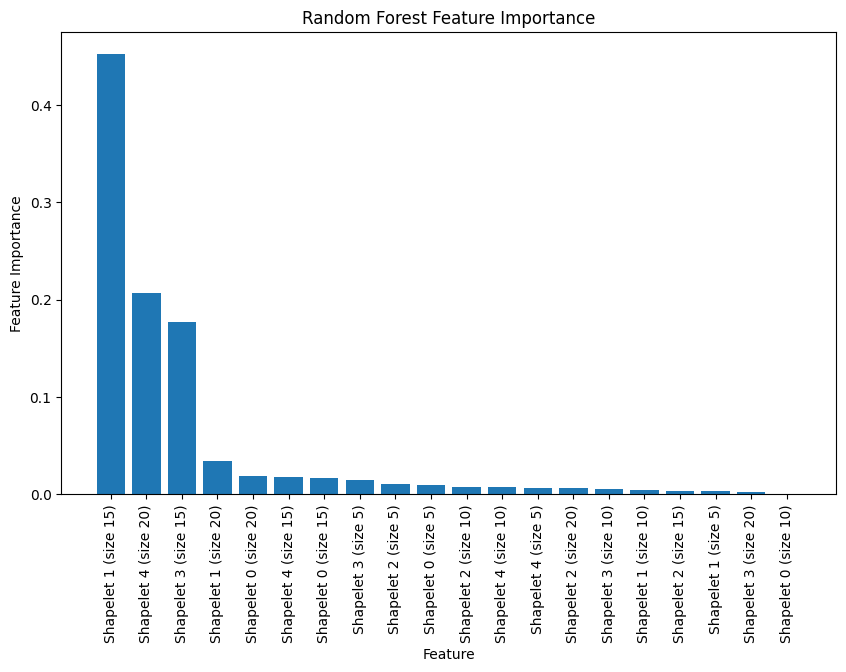

In [614]:
# Visualize feature importance
feature_importance = best_rf.feature_importances_

# Sort indices based on feature importance
sorted_idx = feature_importance.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [615]:
print('Feature importances:')
for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

Feature importances:
Shapelet 1 (size 15): 0.4526003765179806
Shapelet 4 (size 20): 0.20663888742095873
Shapelet 3 (size 15): 0.17670034198061896
Shapelet 1 (size 20): 0.033589669374345536
Shapelet 0 (size 20): 0.01879161418707829
Shapelet 4 (size 15): 0.017865560781280418
Shapelet 0 (size 15): 0.016267611241723108
Shapelet 3 (size 5): 0.014429499780312792
Shapelet 2 (size 5): 0.01072988828776026
Shapelet 0 (size 5): 0.008964409208096037
Shapelet 2 (size 10): 0.007568432864919809
Shapelet 4 (size 10): 0.007088414718289119
Shapelet 4 (size 5): 0.006055138098558106
Shapelet 2 (size 20): 0.005836676768149631
Shapelet 3 (size 10): 0.005157532303788248
Shapelet 1 (size 10): 0.0036578201328942347
Shapelet 2 (size 15): 0.0030954709649041214
Shapelet 1 (size 5): 0.00304381259496185
Shapelet 3 (size 20): 0.0018506499938949076
Shapelet 0 (size 10): 6.819277948530726e-05


In [616]:
shapelets_learned_as_ts.shape

(20, 20, 1)

In [617]:
# Transform the shapelets back to their original shape
shapelets_rescaled = scaler.inverse_transform(shapelets_learned_as_ts)
shapelets_rescaled.shape

Inverse scaling time series with MinMaxScaler


(20, 20, 1)

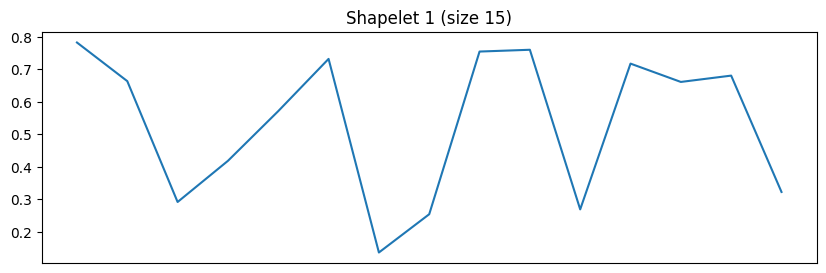

In [619]:
# Plot the three most important shapelets according to feature importances and name according to feature names
n_plotted = 1

shapelets_ordered = shapelets_rescaled[sorted_idx]

shapelets_names_ordered = [feature_names[i] for i in sorted_idx]

plt.figure(figsize=(10, 3))
for i in range(n_plotted):
    plt.subplot(n_plotted, 1, i + 1)
    plt.title(f"{shapelets_names_ordered[i]}")
    plt.plot(shapelets_ordered[i].ravel())
    plt.xticks([])